# Прогнозирование оттока клиентов телекоммуникационной компании 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-задачи" data-toc-modified-id="Описание-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание задачи</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка выборок</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Отчет-по-проекту" data-toc-modified-id="Отчет-по-проекту-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Отчет по проекту</a></span></li></ul></div>

# Описание задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

<b>Описание услуг</b>

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

<b> Описание данных</b>

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Исследовательский анализ данных

In [37]:
#pip install lightgbm

In [38]:
#pip install xgboost

In [39]:
# подгрузим библиотеки

import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
from datetime import date as date_n
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import lightgbm as lgbm
import xgboost as xgb

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve

warnings.filterwarnings('ignore')
state = np.random.RandomState(12345)

pd.options.display.float_format ='{:,.4f}'.format

In [40]:
path = '/datasets/final_provider/'

In [41]:
tables = {'contract': None, 'personal': None, 'internet':  None, 'phone': None}

for table in tables:
 #   tables[table] = pd.read_csv(table + '.csv', index_col=[0])
    tables[table] = pd.read_csv(path+table + '.csv', index_col=[0])

In [42]:
# функция для обзора содержимого таблиц

def table_info(table_ref,table_name):
    print ('\n' + '\033[1m' + 'Таблица: ' + table_name.upper() + '\033[0m')  
    display(table_ref.head(10))
    table_ref.info()
    df_number = table_ref.select_dtypes(include = np.number)
    for col_number in range(0,df_number.shape[1]):
        print(f'\nМинимальное и максимальное значения в колонке {df_number.columns[col_number]} : \
              {df_number.loc[:,df_number.columns[col_number]].min()} и {df_number.loc[:,df_number.columns[col_number]].max()}')
        
    df_not_number = table_ref.select_dtypes(exclude = np.number)
    for col_number in range(0,df_not_number.shape[1]):
        print(f'\nСписок значений в колонке {df_not_number.columns[col_number]}: \
        {(df_not_number.loc[:,df_not_number.columns[col_number]].sort_values().unique())}') 
        print(df_not_number.loc[:,df_not_number.columns[col_number]].value_counts())
    print ('\n\033[1m' + 'Процент пропущенных значений в колонках:' + '\033[0m')
    print(table_ref.isna().mean().sort_values(ascending = False) * 100)

### Анализ данных о договорах с клиентами (таблица contract)

In [43]:
table_info(tables['contract'], 'Данные о договорах с клиентами')


Таблица: ДАННЫЕ О ДОГОВОРАХ С КЛИЕНТАМИ


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.8500,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.9500,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.8500,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3000,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.7000,151.65
9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.6500,820.5
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.1000,1949.4
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.7500,301.9
7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.8000,3046.05


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB

Минимальное и максимальное значения в колонке MonthlyCharges :               18.25 и 118.75

Список значений в колонке BeginDate:         ['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '20

<b> Дополнительное исследование колонки MonthlyCharges:

In [44]:
def hist(data, column):
    print(data.describe())
    data.hist(bins = 100, figsize = (15, 10))
    plt.title('Распределение значений колонки ' + column.lower())
    plt.show()
    plt.figure(figsize=(15,2))
    sn.boxplot(data, color = 'green')
    plt.show()

count   7,043.0000
mean       64.7617
std        30.0900
min        18.2500
25%        35.5000
50%        70.3500
75%        89.8500
max       118.7500
Name: MonthlyCharges, dtype: float64


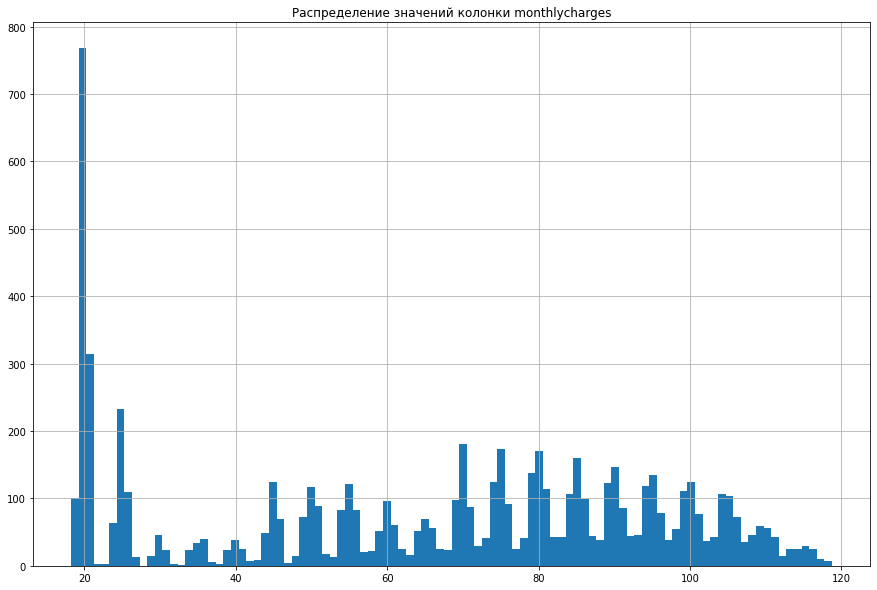

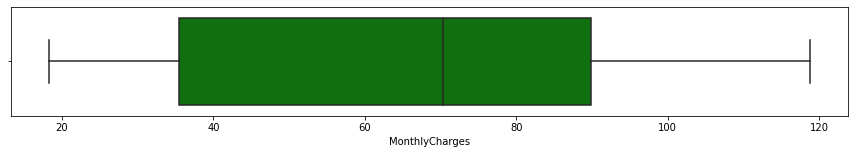

In [45]:
hist(tables['contract']['MonthlyCharges'],'MonthlyCharges')

<b> Выводы: </b>

Таблица содержит 7043 записи, в 7 колонках:

- BeginDate (тип object) - данные о дате начала договора с клиентом. Признак в данной колонке необходимо преобразовать к типу date;
- EndDate (тип object) - данные о дате окончания договора с клиентом. Признак в данной колонке необходимо преобразовать к типу date. Данный признак определяющим для создания целевого признака - отражает информацию о том, разорван ли договор с клиентом или нет. В колонке в 5174 записях присутствует значение 'No' (действующий договор). Если учесть ограничение даты сбора информации (1 февраля 2020 года), то установим для данных записей значение, равное '2020-02-01';  
- Type (тип object) - данные о типе договора (краткосрочный - 'Month-to-month', долгосрочный - 'One year' и 'Two year'). Признак в данной колонке необходимо преобразовать из категориального к числовому типу;  
- PaperlessBilling (тип object) - данные о возможности получение чека в электронном виде. Бинарный признак в данной колонке необходимо преобразовать к числовому типу со значениями 0 и 1;
- PaymentMethod (тип object) - данные о способе расчетов по договору. Признак в данной колонке необходимо преобразовать от категориального к числовому типу;
- MonthlyCharges (тип float64) - данные о месячном размере оплаты по договору. Визуализация данных показала отсутствие выбросов;  
- TotalCharges (тип object) - данные о общем размере оплаты по договору. Признак в данной колонке необходимо преобразовать к типу float64. В данной колонке присутствуют пустые значения, что требует дополнительного анализа.  
    
Поскольку в дальнейшем даты BeginDate и EndDate не будут предъявляться модели (будет строиться прогноз на будущее), то создадим новый признак, отражающий срок действия договора.

Индекс таблицы customerID - уникальный идентификатор клиента.
Пропущенные значения в таблице отсутствуют.

### Анализ персональных данных клиентов (таблица personal)

In [46]:
table_info(tables['personal'], 'Персональные данные клиентов')


Таблица: ПЕРСОНАЛЬНЫЕ ДАННЫЕ КЛИЕНТОВ


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB

Минимальное и максимальное значения в колонке SeniorCitizen :               0 и 1

Список значений в колонке gender:         ['Female' 'Male']
Male      3555
Female    3488
Name: gender, dtype: int64

Список значений в колонке Partner:         ['No' 'Yes']
No     3641
Yes    3402
Name: Partner, dtype: int64

Список значений в колонке Dependents:         ['No' 'Yes']
No     4933
Yes    2110
Name: Dependents, dtype: int64

Процент пропущенных значений в колонках:
gender          0.0000
SeniorCitizen   0.0000
Partner         0.0000
Dependents      0.0000
dtype: float64


<b> Выводы: </b>

Таблица содержит 7043 записи, в 4 колонках:

- gender (тип object) - данные о поле клиента. Бинарный признак в данной колонке необходимо преобразовать к числовому типу со значениями 0 и 1;
- SeniorCitizen (тип int64) - данные о признаке пожилого возраста клиента (пенсионер); 
- Partner (тип object) - данные о наличии партнера (супруга). Бинарный признак в данной колонке необходимо преобразовать к числовому типу со значениями 0 и 1;  
- Dependents (тип object) - данные о наличии иждивенцев. Бинарный признак в данной колонке необходимо преобразовать к числовому типу со значениями 0 и 1;  

Индекс таблицы customerID - уникальный идентификатор клиента.
Пропущенные значения в таблице отсутствуют.

### Анализ данных об интернет-услугах (таблица internet)

In [47]:
table_info(tables['internet'], 'Данные об интернет-услугах')


Таблица: ДАННЫЕ ОБ ИНТЕРНЕТ-УСЛУГАХ


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB

Список значений в колонке InternetService:         ['DSL' 'Fiber optic']
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Список значений в колонке OnlineSecurity:         ['No' 'Yes']
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

Список значений в колонке OnlineBackup:         ['No' 'Yes']
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

Список значений в колонке DevicePro

<b> Выводы: </b>

Таблица содержит 5517 записей, в 7 колонках:

- InternetService (тип object) - данные о типе подключения интернета. Признак в данной колонке необходимо преобразовать от категориального к числовому типу;
- OnlineSecurity (тип object) - данные о наличии  блокировки небезопасных сайтов. Бинарный признак в данной колонке необходимо преобразовать к числовому типу со значениями 0 и 1; 
- OnlineBackup (тип object) - данные о наличии облачного хранилища файлов для резервного копирования данных. Бинарный признак в данной колонке необходимо преобразовать к числовому типу со значениями 0 и 1;  
- DeviceProtection (тип object) - данные о наличии антивируса. Бинарный признак в данной колонке необходимо преобразовать к числовому типу со значениями 0 и 1;  
- TechSupport (тип object) - данные о наличии выделенной линии технической поддержки. Бинарный признак в данной колонке необходимо преобразовать к числовому типу со значениями 0 и 1;    
- StreamingTV (тип object) - данные о наличии стримингового ТВ. Бинарный признак в данной колонке необходимо преобразовать к числовому типу со значениями 0 и 1;    
- StreamingMovies (тип object) - данные о наличии каталога фильмов. Бинарный признак в данной колонке необходимо преобразовать к числовому типу со значениями 0 и 1;      

Индекс таблицы customerID - уникальный идентификатор клиента.
Пропущенные значения в таблице отсутствуют.

### Анализ данных об услугах телефонии (таблица phone)

In [48]:
table_info(tables['phone'], 'Данные об услугах телефонии')


Таблица: ДАННЫЕ ОБ УСЛУГАХ ТЕЛЕФОНИИ


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
7892-POOKP,Yes
6388-TABGU,No
9763-GRSKD,No
7469-LKBCI,No


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB

Список значений в колонке MultipleLines:         ['No' 'Yes']
No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Процент пропущенных значений в колонках:
MultipleLines   0.0000
dtype: float64


<b> Выводы: </b>

Таблица содержит 6361 запись, в 1 колонке:

- MultipleLines (тип object) - данные о наличии многоканальной телефонии. Признак в данной колонке необходимо преобразовать к числовому со значениями 0 и 1.

Индекс таблицы customerID - уникальный идентификатор клиента.
Пропущенные значения в таблице отсутствуют.

# Предобработка данных

1. Приведем название колонок всех таблиц к нижнему регистру:    

In [49]:
for table in tables:
    tables[table].columns = tables[table].columns.str.lower()

2. Заполним значения No в колонке enddate значением '2020-02-01', преобразуем даты к типу date:

In [50]:
tables['contract'].loc[tables['contract']['enddate'] == 'No', 'enddate'] = '2020-02-01'
tables['contract']['begindate'] = pd.to_datetime(tables['contract']['begindate'],format='%Y.%m.%d')
tables['contract']['enddate'] = pd.to_datetime(tables['contract']['enddate'],format='%Y.%m.%d')

3. Создадим целевой признак (leaving), со значением, равным 1, для клиентов, расторгших договор (значение колонки enddate ранее 1 февраля 2020 года), и значение, равным 0 для клиентов с действующим договором (значение поля enddate равно 1 февраля 2020 года):

In [51]:
tables['contract'].loc[tables['contract']['enddate'] != '2020-02-01', 'leaving'] = 1
tables['contract'].loc[tables['contract']['enddate'] == '2020-02-01', 'leaving'] = 0
tables['contract']['leaving'] = tables['contract']['leaving'].astype('int')

4. Проанализируем пустые значения в колонке totalcharges:

In [52]:
tables['contract'][tables['contract']['totalcharges']==' ']

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,leaving
customerID,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.5500,,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.2500,,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.8500,,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.7500,,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.0500,,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.8500,,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.3500,,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.0000,,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.7000,,0


Записи с незаполненным значением в колонке totalcharges датируются датой начала, равной 2020-02-01 и соответствующей сроку окончания сбора статистической информации. То есть по ним еще не собрана статистика. Заменим отсутствующие значения в этих записях значением колонки monthlycharges, поскольку totalcharges содержит в себе monthlycharges.

In [53]:
tables['contract'].loc[tables['contract']['totalcharges'] == ' ',['totalcharges']] = \
tables['contract'].loc[tables['contract']['totalcharges'] == ' ']['monthlycharges']

tables['contract']['totalcharges'] = tables['contract']['totalcharges'].astype('float')

count   7,043.0000
mean    2,279.7990
std     2,266.7302
min        18.8000
25%       398.5500
50%     1,394.5500
75%     3,786.6000
max     8,684.8000
Name: totalcharges, dtype: float64


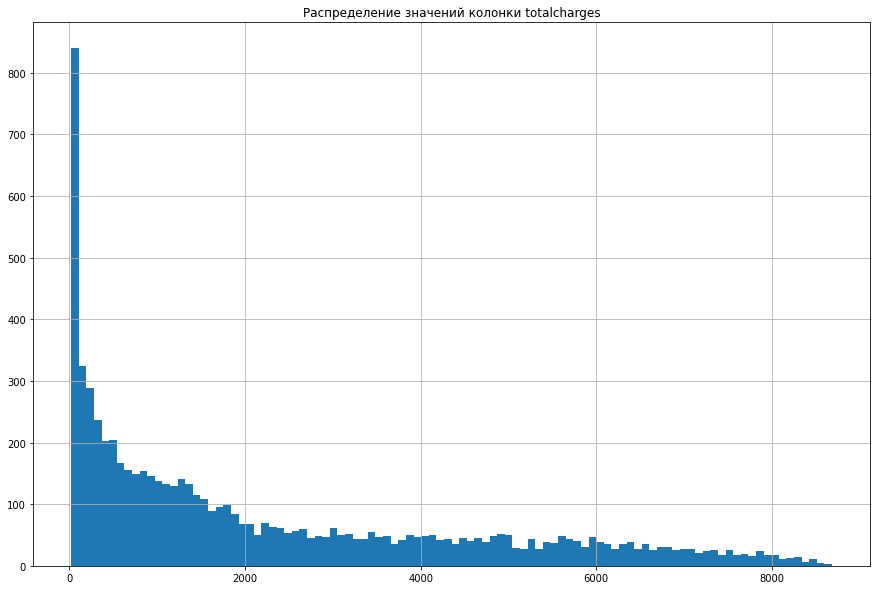

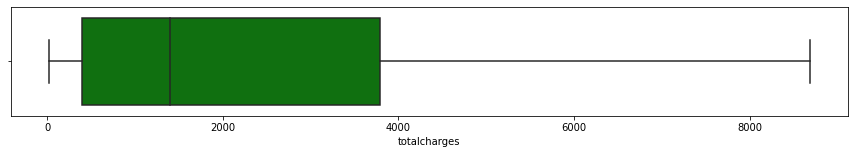

In [54]:
hist(tables['contract']['totalcharges'],'totalcharges')

Выбросы в колонке totalcharges отсутствуют.

5. На основе признаков begindate и enddate создадим новый признак (term), отражающий срок действия договора в днях. Признаки begindate и enddate для дальнейшего исследования исключим:

In [55]:
tables['contract']['term'] = tables['contract'].enddate - tables['contract'].begindate
tables['contract']['term'] = tables['contract']['term'].dt.days.astype('int')
tables['contract'] = tables['contract'].drop(['begindate','enddate'],axis = 1)


count   7,043.0000
mean      985.9962
std       747.5878
min         0.0000
25%       273.0000
50%       883.0000
75%     1,676.0000
max     2,191.0000
Name: term, dtype: float64


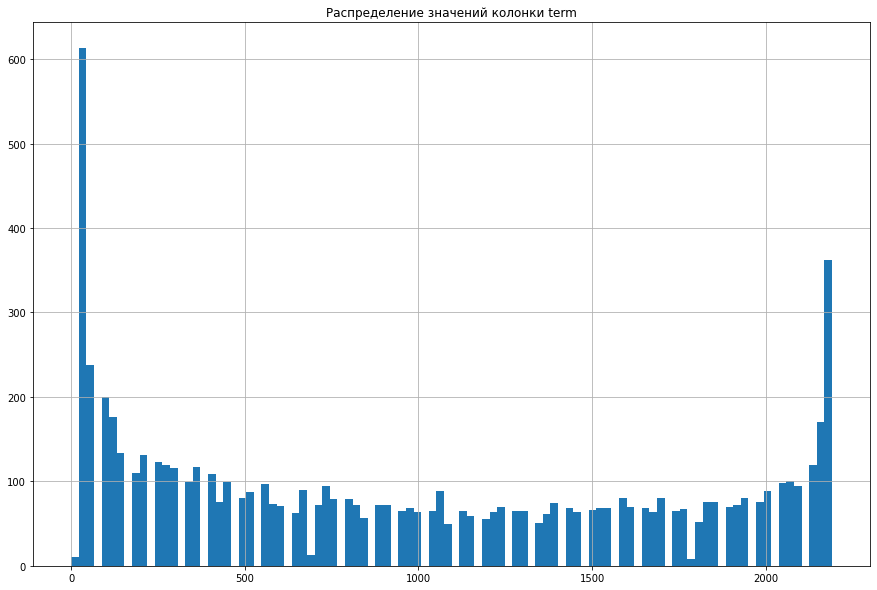

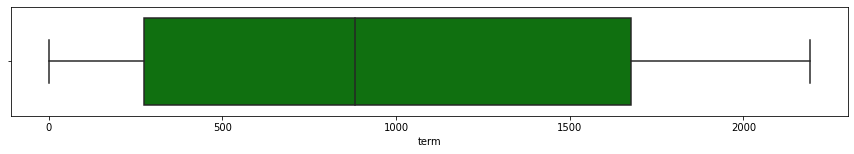

In [56]:
hist(tables['contract']['term'],'term')

Выбросы в колонке term отсутствуют.

In [57]:
tables

{'contract':                       type paperlessbilling              paymentmethod  \
 customerID                                                               
 7590-VHVEG  Month-to-month              Yes           Electronic check   
 5575-GNVDE        One year               No               Mailed check   
 3668-QPYBK  Month-to-month              Yes               Mailed check   
 7795-CFOCW        One year               No  Bank transfer (automatic)   
 9237-HQITU  Month-to-month              Yes           Electronic check   
 ...                    ...              ...                        ...   
 6840-RESVB        One year              Yes               Mailed check   
 2234-XADUH        One year              Yes    Credit card (automatic)   
 4801-JZAZL  Month-to-month              Yes           Electronic check   
 8361-LTMKD  Month-to-month              Yes               Mailed check   
 3186-AJIEK        Two year              Yes  Bank transfer (automatic)   
 
           

6. Объединим данные всех таблиц:

In [58]:
itog = pd.concat([tables['contract'], tables['personal'], tables['internet'], tables['phone']], axis=1)
itog.sample(10)

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,leaving,term,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
customerID,,,,,,,,,,,,,,,,,,,
9560-BBZXK,Two year,No,Bank transfer (automatic),31.0500,"1,126.3500",0,1095,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
2346-DJQTB,Month-to-month,No,Electronic check,24.1500,812.5000,0,1067,Female,0,No,No,DSL,No,No,No,No,No,No,NaN
7159-NOKYQ,Two year,Yes,Electronic check,93.1500,"6,368.2000",0,2041,Male,0,Yes,No,Fiber optic,No,Yes,Yes,No,No,Yes,Yes
9140-CZQZZ,Two year,Yes,Bank transfer (automatic),79.6000,"5,515.8000",0,2071,Female,0,Yes,No,DSL,Yes,Yes,No,Yes,Yes,Yes,No
0258-NOKBL,Month-to-month,No,Electronic check,90.4000,268.4500,0,92,Male,0,No,No,Fiber optic,No,Yes,Yes,No,No,Yes,No
4199-QHJNM,Two year,No,Bank transfer (automatic),102.9000,"6,989.7000",0,2041,Male,1,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,Yes
4236-XPXAV,Month-to-month,Yes,Mailed check,99.1500,465.0500,1,153,Female,0,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,No
8709-KRDVL,Month-to-month,Yes,Electronic check,100.0000,"3,320.6000",0,1006,Female,0,No,No,Fiber optic,No,Yes,No,No,Yes,Yes,Yes
5684-FJVYR,Two year,Yes,Bank transfer (automatic),90.3500,"6,563.4000",0,2191,Female,0,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,No,No,Yes


7. Исследуем пропуски итоговой таблицы:

In [59]:
itog.isna().sum()

type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
leaving                0
term                   0
gender                 0
seniorcitizen          0
partner                0
dependents             0
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
multiplelines        682
dtype: int64

Существует 2 вида пропусков, связанных с:

1) отсутствием данных в таблице интернет-услуг;

2) отсутствием данных в таблице звонков.

Отсутствующие данные по интернет-услугам и звонкам заменим на значение No.

In [60]:
itog.fillna('No', inplace = True)

In [61]:
itog.isna().sum()

type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
leaving             0
term                0
gender              0
seniorcitizen       0
partner             0
dependents          0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
multiplelines       0
dtype: int64

Пропуски в итоговой таблице отсутствуют.

<b> Задача 1 Телеком: исследование оттока клиентов </b>

Пока создаётся модель прогнозирования оттока клиентов, отдел маркетинга «Ниединогоразрыва.ком» приступает к проработке способов их удержания. Вам предстоит собрать нужную для этого информацию.

Сравните распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл. Для каждой группы посчитайте статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Постройте гистограммы распределения.

Сравните поведение клиентов этих двух групп. Для каждой постройте два любых графика, изображающих:

долю пользователей телефонной связи;
долю интернет-пользователей.

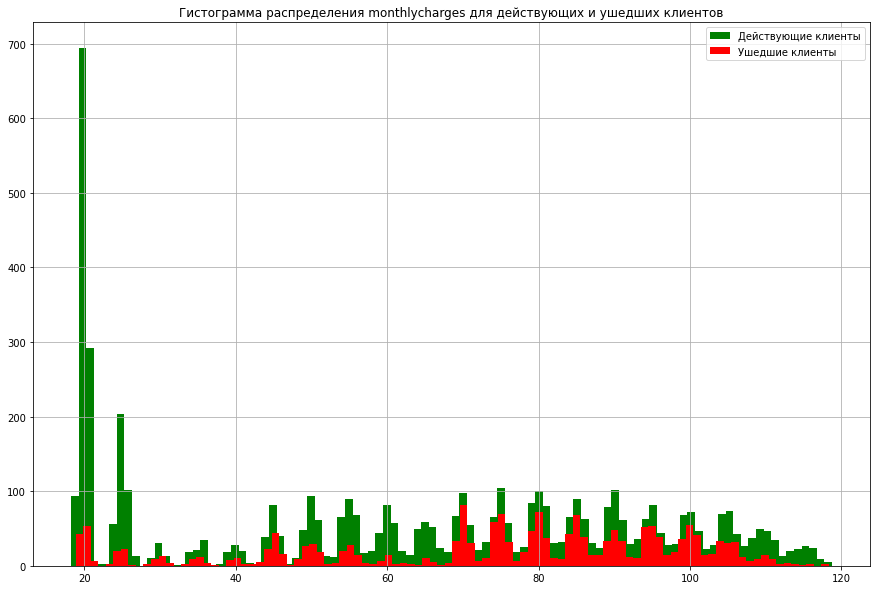

In [62]:
plt.figure(figsize=(15,10))
ax = plt.subplot()
itog[itog['leaving']==0]['monthlycharges'].hist(bins = 100, color = 'green', ax = ax)

itog[itog['leaving']==1]['monthlycharges'].hist(bins = 100, color = 'red', ax = ax)
plt.title('Гистограмма распределения monthlycharges для действующих и ушедших клиентов')
plt.legend(['Действующие клиенты','Ушедшие клиенты'])
plt.show()

Сравнительный анализ показывает схожесть распределения значений monthlycharges между выборками действующих клиентов и ушедшими клиентов для диапазона от 30 до 90. Для значений до 30 частоты для ушедших клиентов значительно ниже. Данный факт свидетельствует о том, что размер месячного платежа влияет на отток клиентов: клиенты реже уходят при значении ежемесячного платежа 30 и ниже.

In [63]:
print('\033[1mСтатистика monthlycharges для действующих клиентов:\033[0m')
print(itog[itog['leaving']==0]['monthlycharges'].describe())
print('\033[1mСтатистика monthlycharges для ушедших клиентов:\033[0m')
print(itog[itog['leaving']==1]['monthlycharges'].describe())

Статистика monthlycharges для действующих клиентов:
count   5,174.0000
mean       61.2651
std        31.0926
min        18.2500
25%        25.1000
50%        64.4250
75%        88.4000
max       118.7500
Name: monthlycharges, dtype: float64
Статистика monthlycharges для ушедших клиентов:
count   1,869.0000
mean       74.4413
std        24.6661
min        18.8500
25%        56.1500
50%        79.6500
75%        94.2000
max       118.3500
Name: monthlycharges, dtype: float64


Text(0.5, 1.0, 'График распределения monthlycharges')

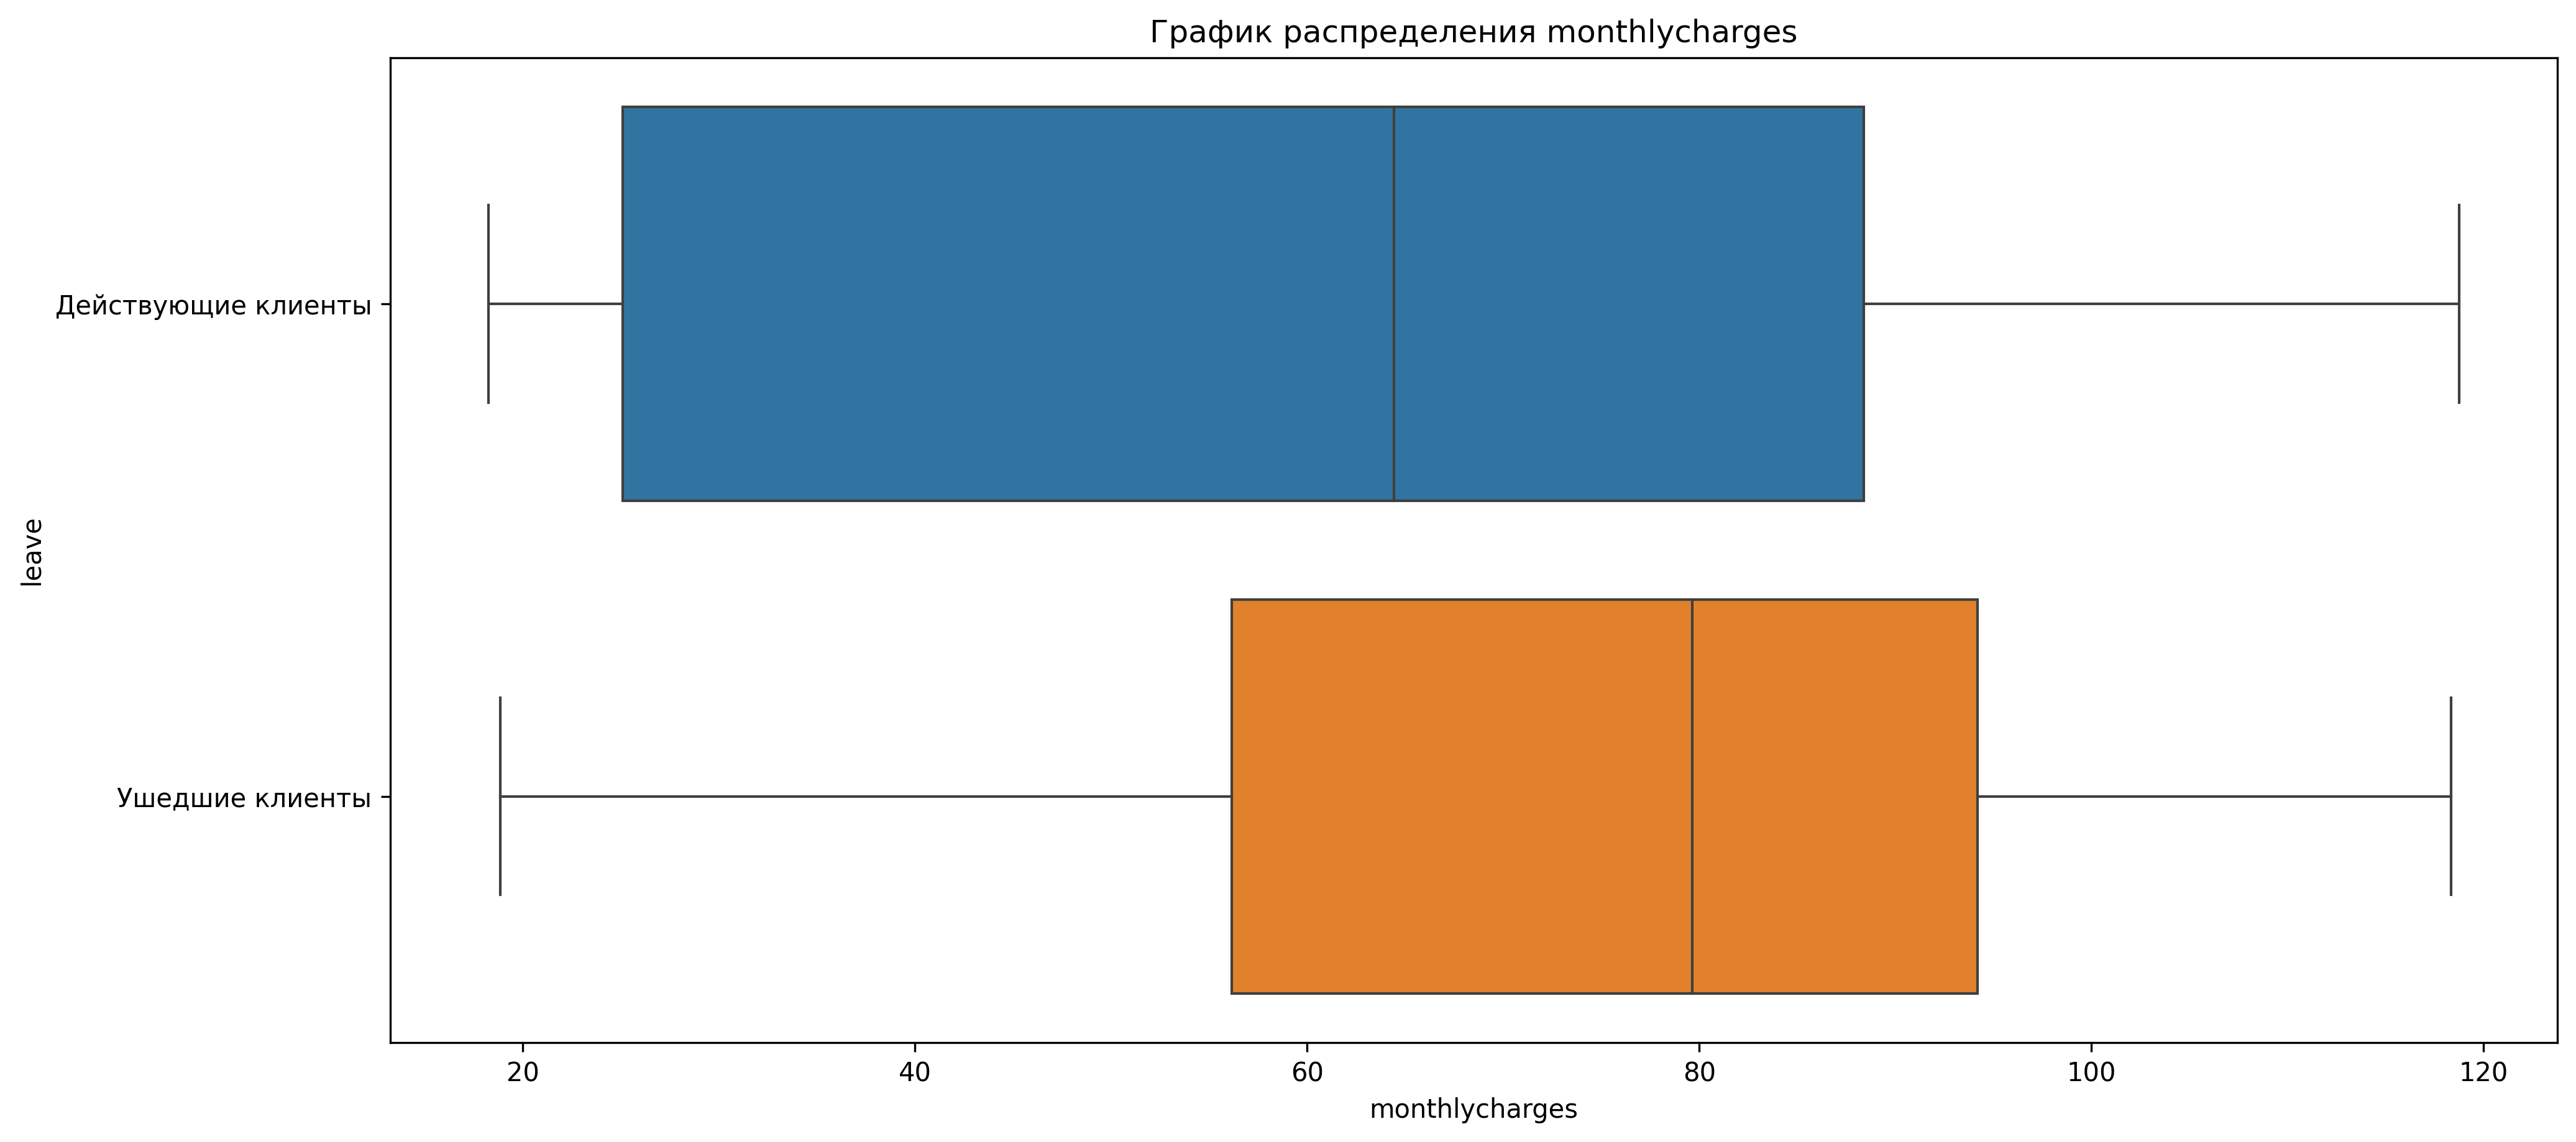

In [64]:
fig = plt.subplots(figsize=(15, 7), dpi= 300)
data1 = pd.DataFrame(itog[itog['leaving']==0]['monthlycharges'])
data1['leave'] = 'Действующие клиенты'
data2 = pd.DataFrame(itog[itog['leaving']==1]['monthlycharges'])
data2['leave'] = 'Ушедшие клиенты'
data = pd.concat([data1, data2], axis=0, join='outer', ignore_index = True)
sn.boxplot( x=data['monthlycharges'], y = data['leave'], orient="h",notch=False, linewidth=1)
plt.title('График распределения monthlycharges')



Исследуем другие факторы, влияющие на отток клиента:

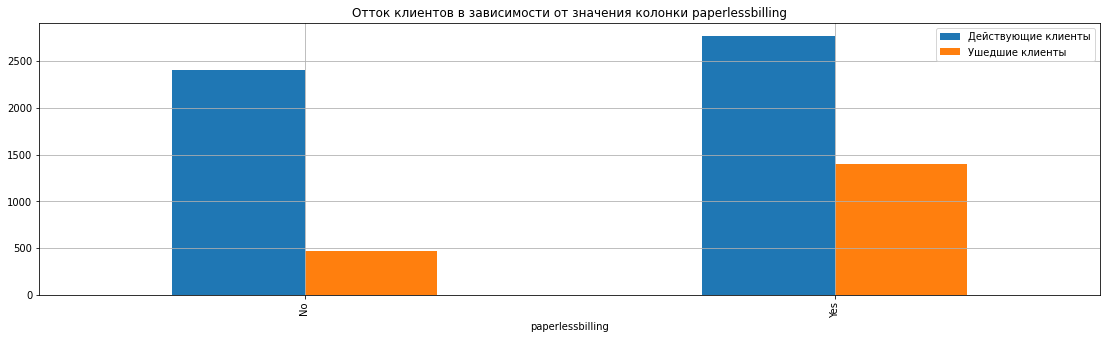

No handles with labels found to put in legend.
No handles with labels found to put in legend.


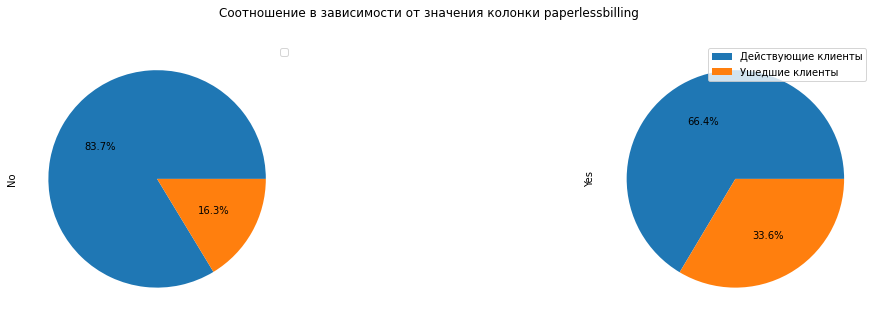

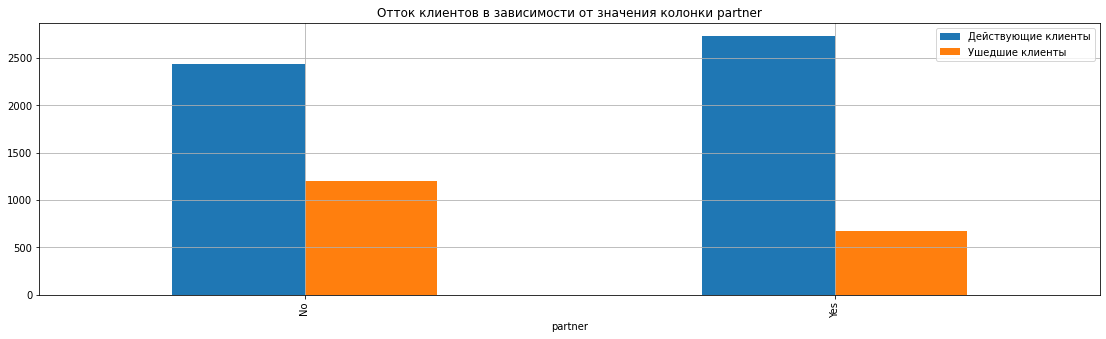

No handles with labels found to put in legend.
No handles with labels found to put in legend.


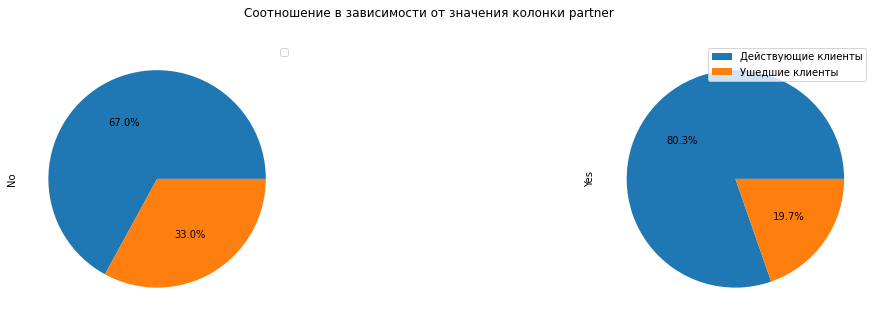

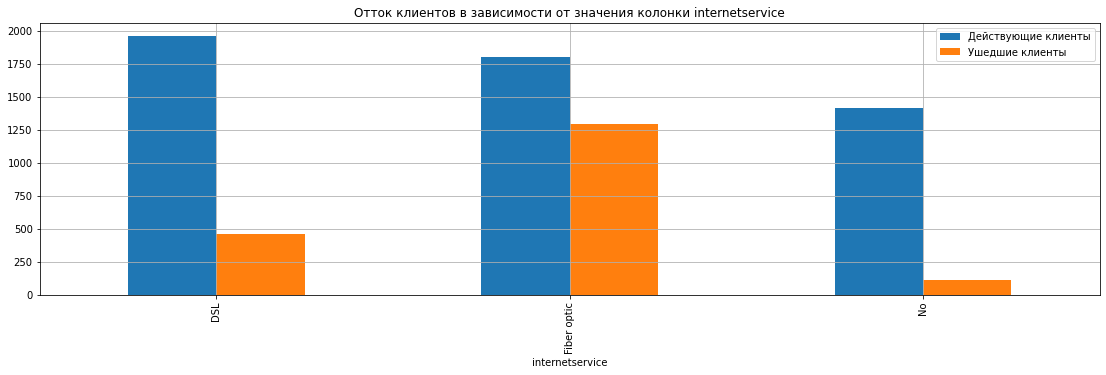

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


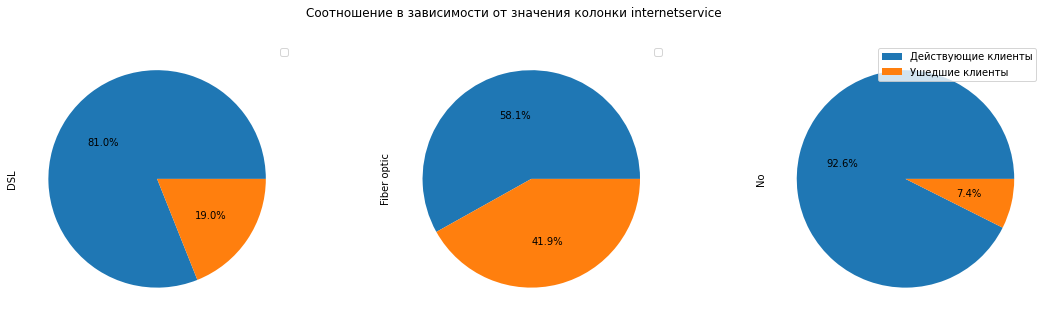

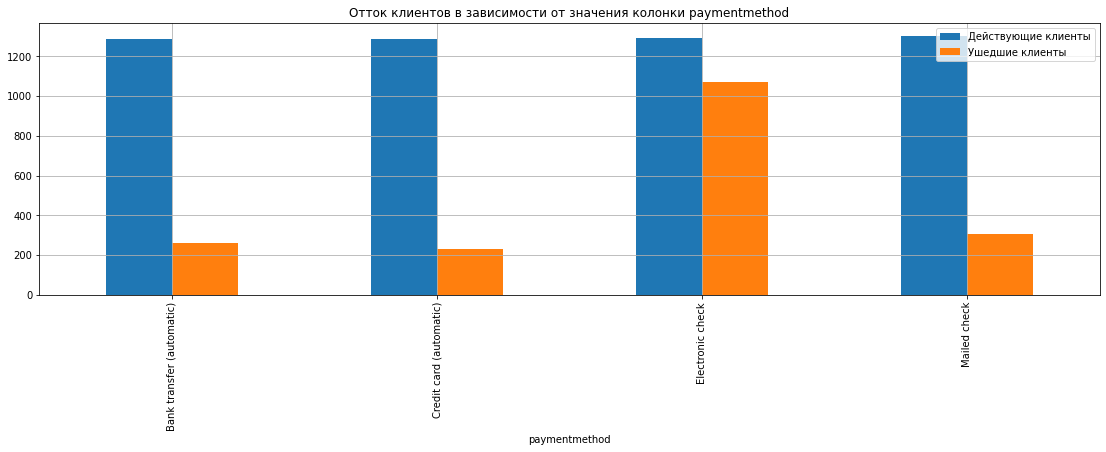

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


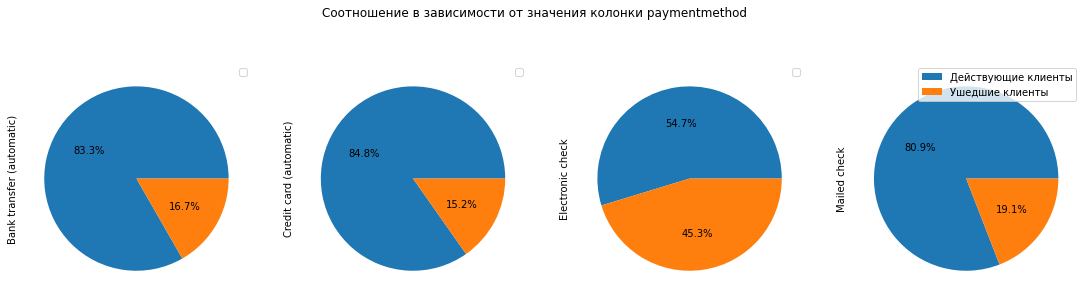

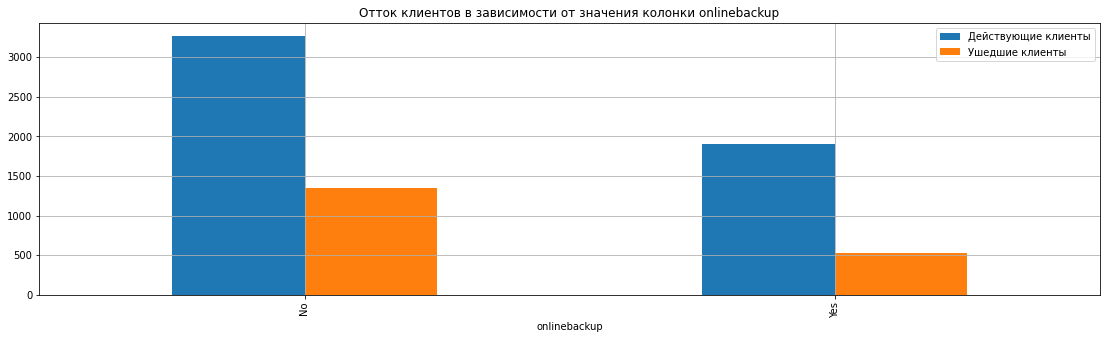

No handles with labels found to put in legend.
No handles with labels found to put in legend.


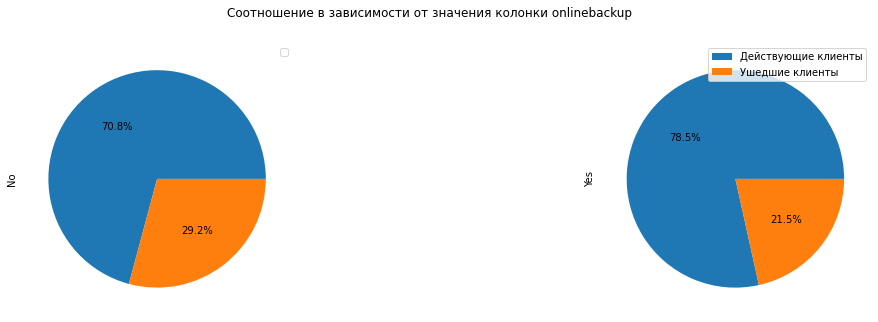

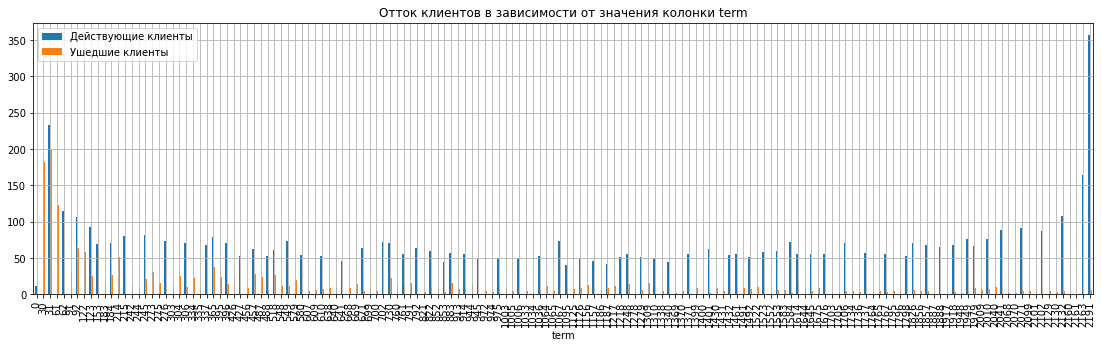

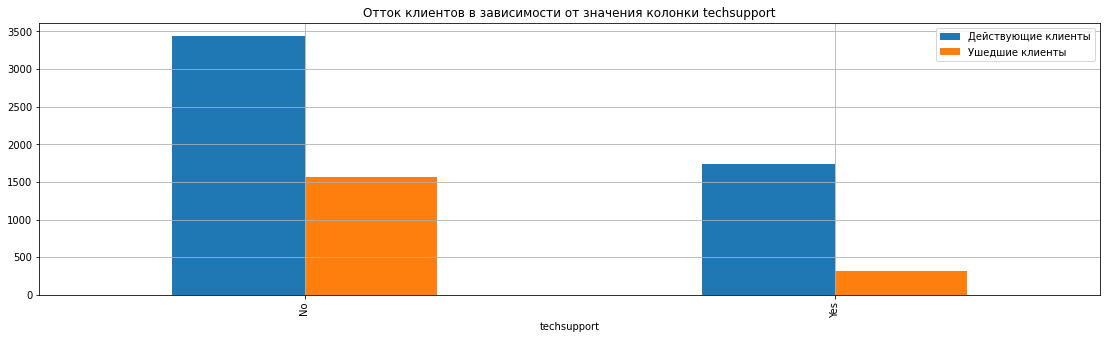

No handles with labels found to put in legend.
No handles with labels found to put in legend.


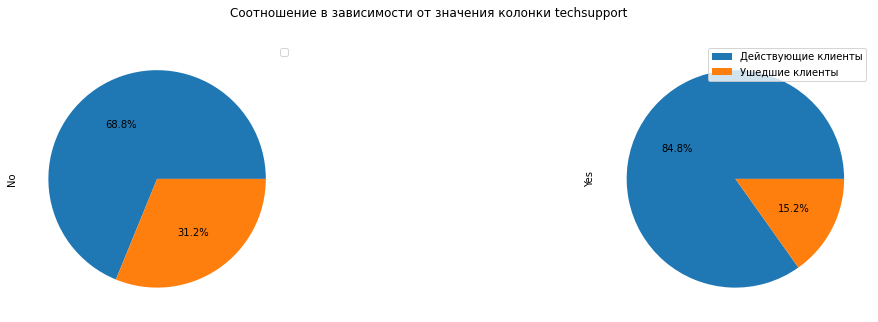

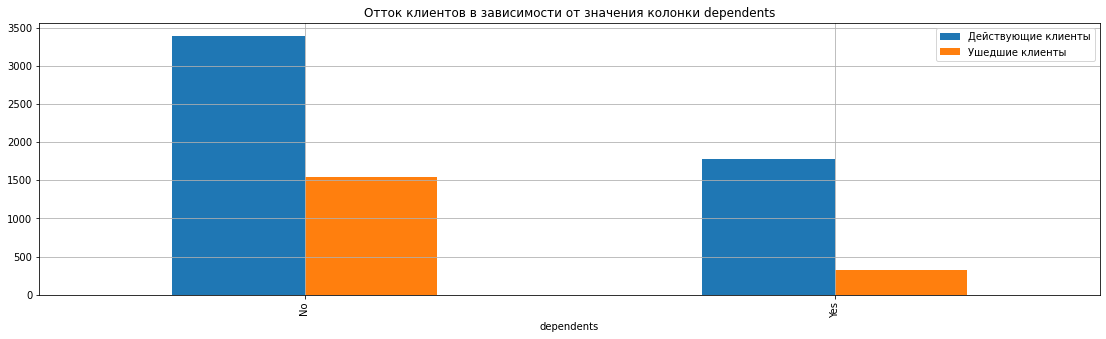

No handles with labels found to put in legend.
No handles with labels found to put in legend.


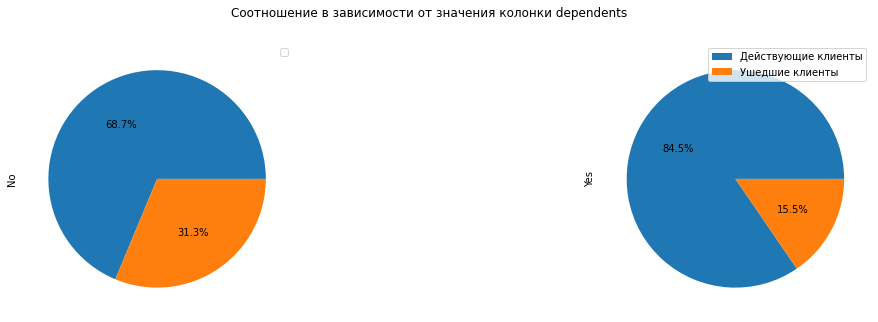

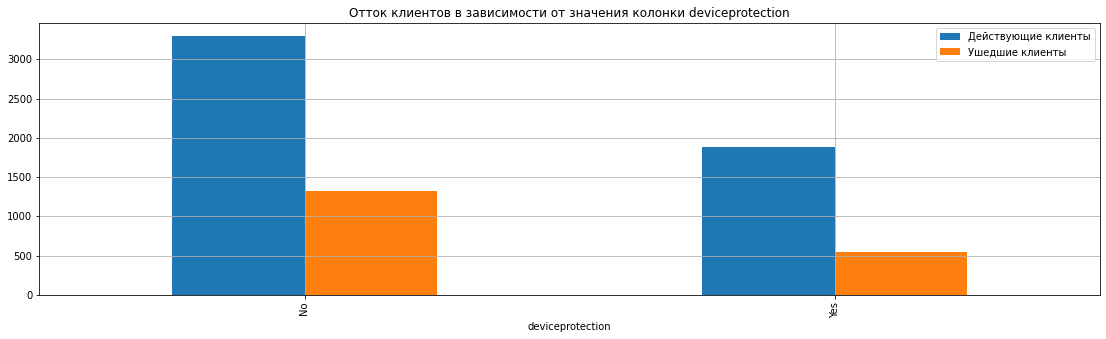

No handles with labels found to put in legend.
No handles with labels found to put in legend.


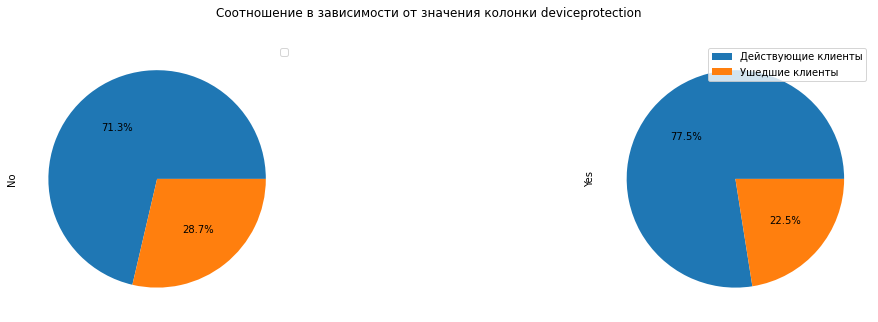

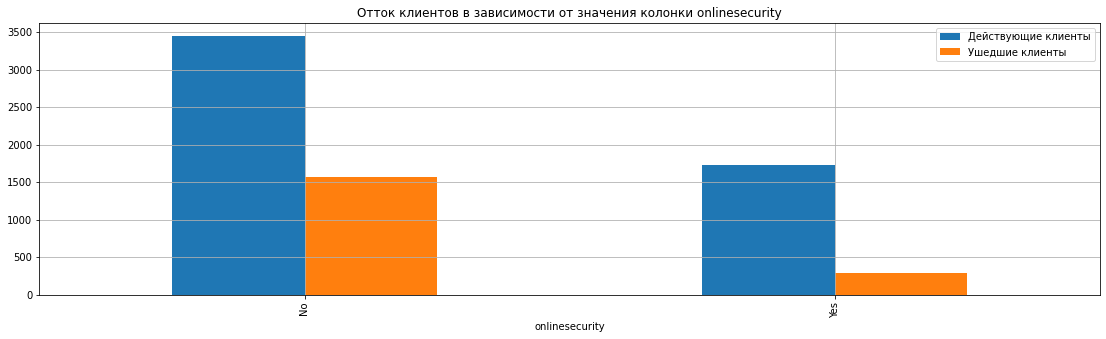

No handles with labels found to put in legend.
No handles with labels found to put in legend.


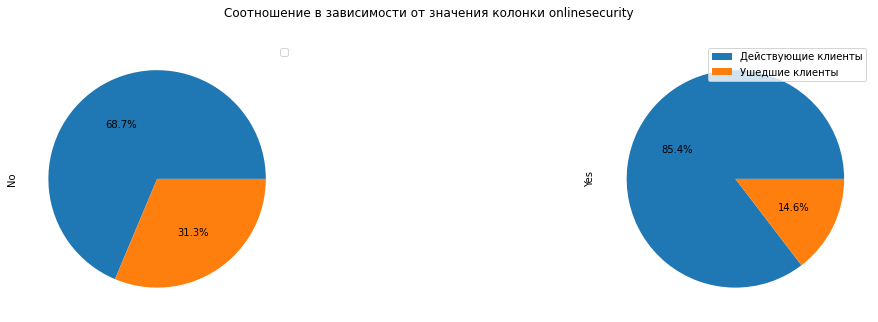

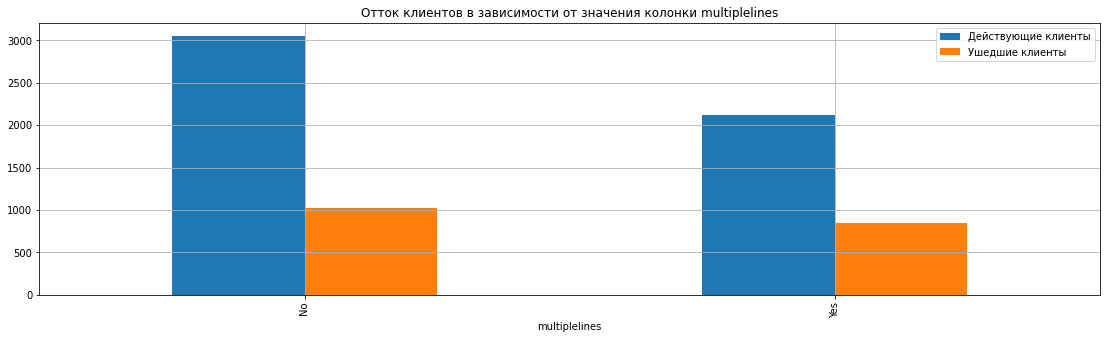

No handles with labels found to put in legend.
No handles with labels found to put in legend.


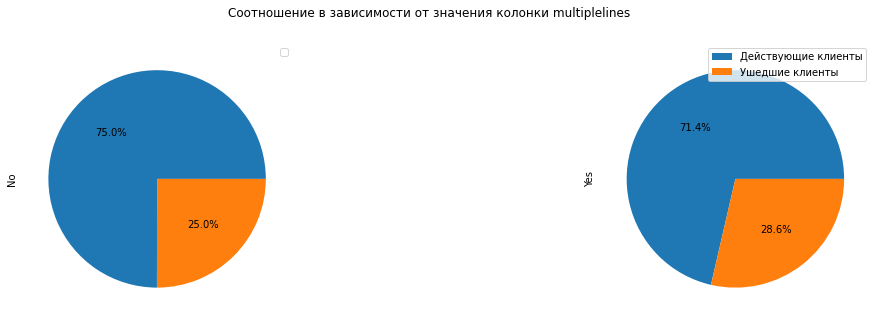

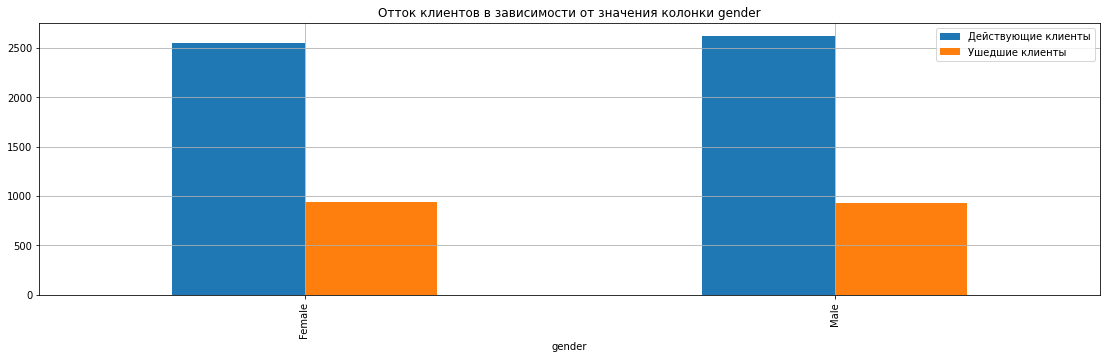

No handles with labels found to put in legend.
No handles with labels found to put in legend.


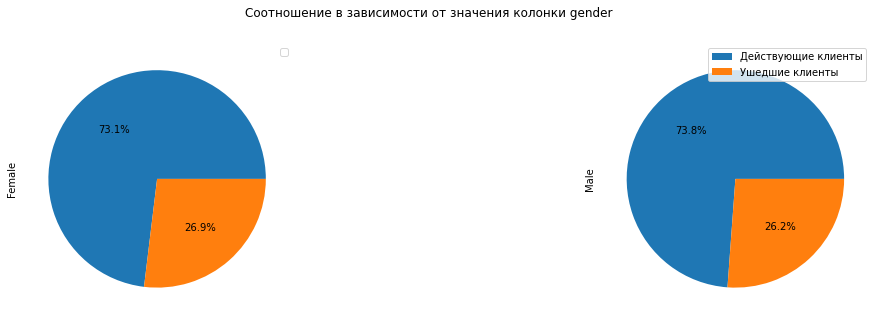

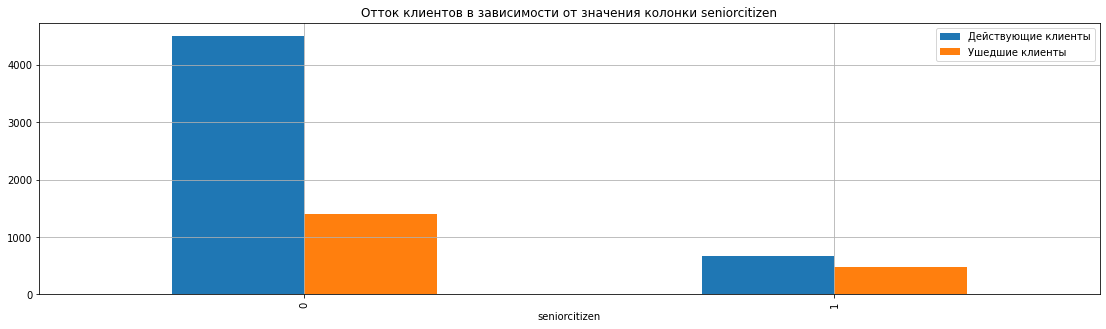

No handles with labels found to put in legend.
No handles with labels found to put in legend.


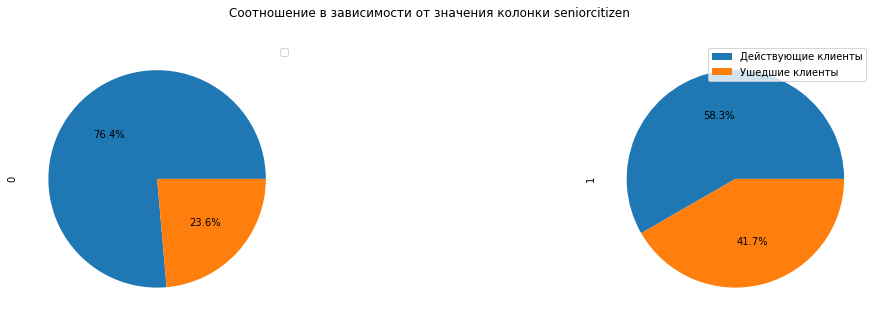

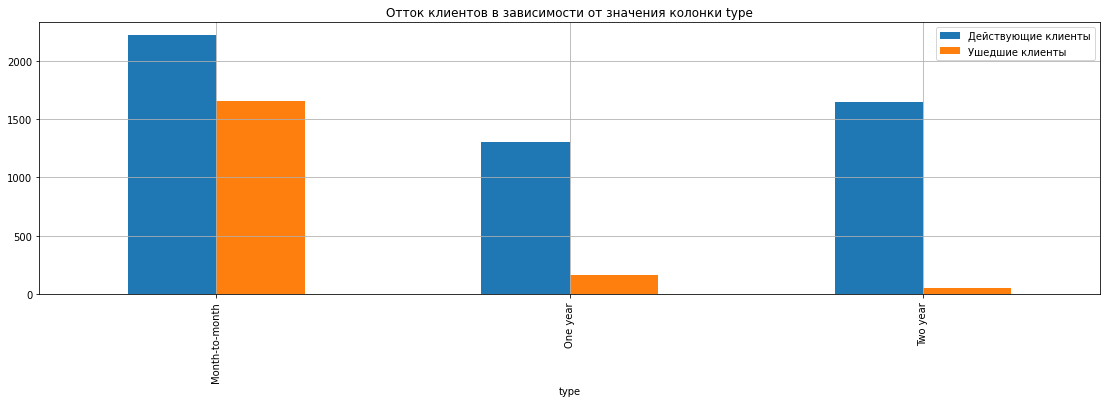

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


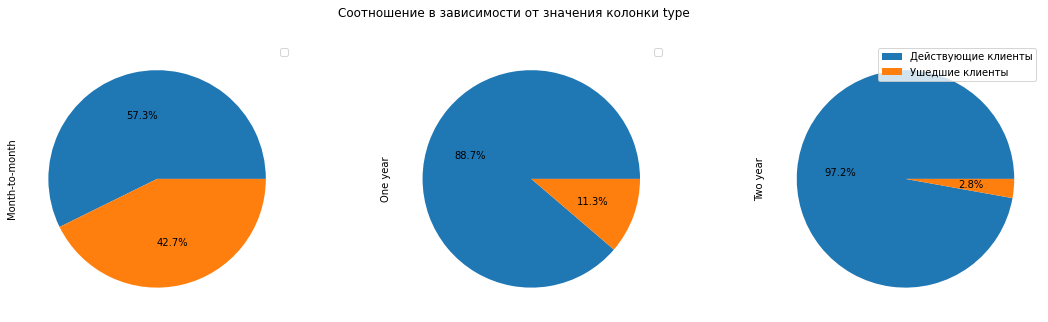

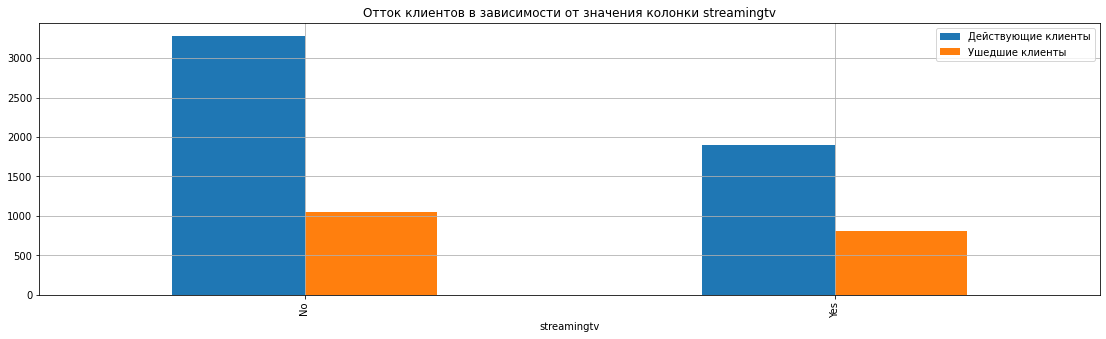

No handles with labels found to put in legend.
No handles with labels found to put in legend.


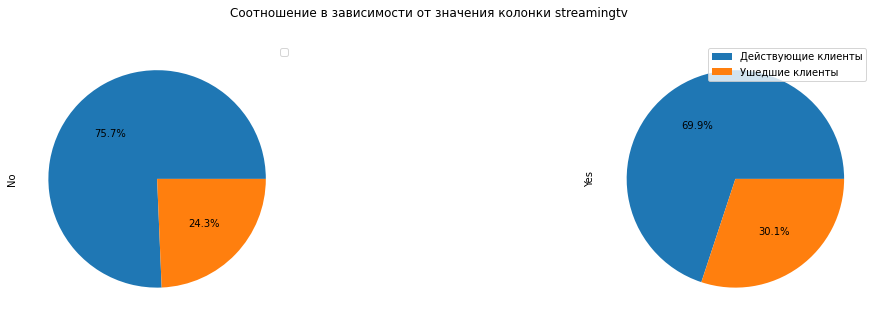

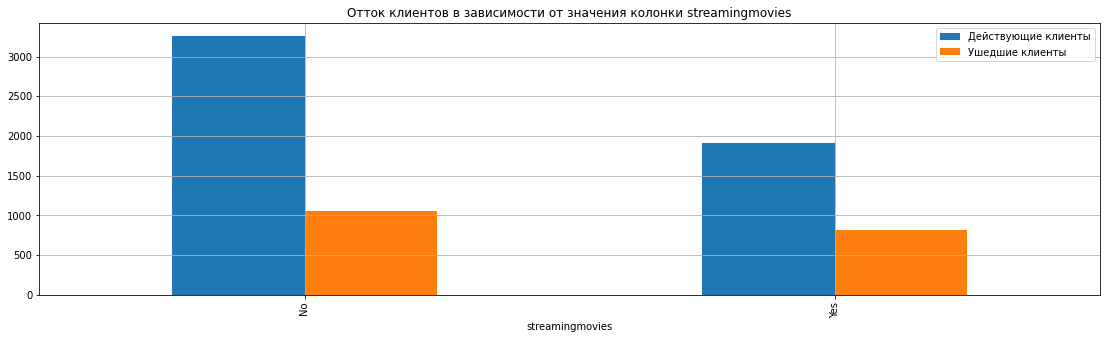

No handles with labels found to put in legend.
No handles with labels found to put in legend.


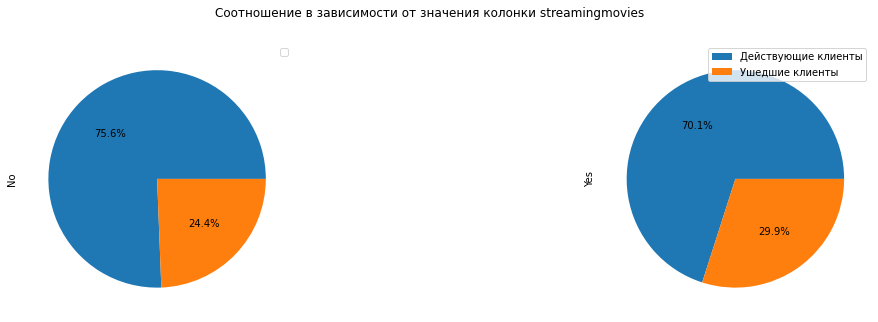

In [65]:
itog['customerid'] = itog.index
not_columns = ['leaving', 'monthlycharges', 'totalcharges','customerid']
for columns in (list(set(itog.columns)-set(not_columns))):
    itog.pivot_table(index = [columns], columns='leaving',  values = 'customerid', aggfunc = 'count').plot.bar(figsize =(19, 5), grid = True, title = 'Отток клиентов в зависимости от значения колонки ' + columns)
    plt.legend(['Действующие клиенты','Ушедшие клиенты'])
    plt.show()
    if columns != 'term':
        itog.pivot_table(index = ['leaving'], columns=[columns],  values = 'customerid', aggfunc = 'count').plot.pie(labels=None, subplots = True, autopct='%1.1f%%', figsize =(19, 5), grid = True, title = 'Соотношение в зависимости от значения колонки ' + columns)    
        plt.legend(['Действующие клиенты','Ушедшие клиенты'])
#    handles, labels = ax.get_legend_handles_labels()
        plt.show()

    
itog = itog.drop('customerid', axis = 1)    

Установлены следующие закономерности:

1) Доля ушедших клиентов выше при электронной оплате услуг (колонка paperlessbilling);

2) Доля ушедших клиентов выше среди категории клиентов, не вступивших в брак (колонка partner);

3) Доля ушедших клиентов выше среди категории клиентов с подключением интернета Fiber optic, и ниже среди категории клиентов, не имеющих подключение к интернету  (колонка internetservice);

4) Доля ушедших клиентов выше среди категории клиентов с электронным типом платежа Electronic check, но нет различия в доле ушедших клиентов для Mailed check, Credit card (automatic), Bank transfer (automatic)  (колонка paymentmethod);

5) Наличие услуги onlinebackup не сильно влияет на отток клиентов (колонка onlinebackup);

6) Доля ушедших клиентов высока для срока договора, равного 1 месяцу. Возможно это клиенты, привлеченные какой-либо акцией, интерес к дальнейшему продолжению договора - потерян (колонка term);

7) Доля ушедших клиентов выше при отсутствии техподдержки (колонка techsupport);

8) Доля ушедших клиентов выше для категории клиентов без иждивенцев (колонка dependents), так же как и для не вступивших в брак;

9) Наличие услуги deviceprotection не сильно влияет на отток клиентов (колонка deviceprotection);  

10) Доля ушедших клиентов выше при отсутствии услуги onlinesecurity (колонка onlinesecurity);

11) Наличие услуги multiplelines не сильно влияет на отток клиентов (колонка multiplelines);

12) Пол клиентов не влияет на отток клиентов (колонка gender);

13) Пенсионеры чаще разрывают договор на услуги (колонка seniorsitizen);

14) Очень большая доля ушедших клиентов используют краткосрочные договора с помесячной оплатой. Чем больше срок договора, тем доля ушедших клиентов ниже (колонка type);

15) Наличие услуги streamingtv незначительно увеличивает долю ушедших клиентов (колонка streamingtv);

16) Наличие услуги streamingmovies также незначительно увеличивает долю ушедших клиентов (колонка streamingmovies).

# Подготовка выборок

1. Кодирование категориальных признаков:

In [66]:
display(itog)

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,leaving,term,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.8500,29.8500,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.9500,"1,889.5000",0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.8500,108.1500,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.3000,"1,840.7500",0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.7000,151.6500,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,One year,Yes,Mailed check,84.8000,"1,990.5000",0,730,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
2234-XADUH,One year,Yes,Credit card (automatic),103.2000,"7,362.9000",0,2191,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4801-JZAZL,Month-to-month,Yes,Electronic check,29.6000,346.4500,0,337,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No


In [67]:

itog = itog.replace('Yes', 1)
itog = itog.replace('No', 0)
itog = itog.replace('Male', 1)
itog = itog.replace('Female', 0)


itog = pd.get_dummies(itog, drop_first = True)
itog.head()

,paperlessbilling,monthlycharges,totalcharges,leaving,term,gender,seniorcitizen,partner,dependents,onlinesecurity,...,streamingtv,streamingmovies,multiplelines,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,internetservice_DSL,internetservice_Fiber optic
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,29.8500,29.8500,0,31,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
5575-GNVDE,0,56.9500,"1,889.5000",0,1036,1,0,0,0,1,...,0,0,0,1,0,0,0,1,1,0
3668-QPYBK,1,53.8500,108.1500,1,61,1,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
7795-CFOCW,0,42.3000,"1,840.7500",0,1371,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
9237-HQITU,1,70.7000,151.6500,1,61,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [68]:
display(itog)

,paperlessbilling,monthlycharges,totalcharges,leaving,term,gender,seniorcitizen,partner,dependents,onlinesecurity,...,streamingtv,streamingmovies,multiplelines,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,internetservice_DSL,internetservice_Fiber optic
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,29.8500,29.8500,0,31,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
5575-GNVDE,0,56.9500,"1,889.5000",0,1036,1,0,0,0,1,...,0,0,0,1,0,0,0,1,1,0
3668-QPYBK,1,53.8500,108.1500,1,61,1,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
7795-CFOCW,0,42.3000,"1,840.7500",0,1371,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
9237-HQITU,1,70.7000,151.6500,1,61,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,1,84.8000,"1,990.5000",0,730,1,0,1,1,1,...,1,1,1,1,0,0,0,1,1,0
2234-XADUH,1,103.2000,"7,362.9000",0,2191,0,0,1,1,0,...,1,1,1,1,0,1,0,0,0,1
4801-JZAZL,1,29.6000,346.4500,0,337,0,0,1,1,1,...,0,0,0,0,0,0,1,0,1,0


2. Исследование корреляции признаков:


Корреляция


,monthlycharges,totalcharges,term
monthlycharges,1.0000,0.6512,0.2478
totalcharges,0.6512,1.0000,0.8261
term,0.2478,0.8261,1.0000


<AxesSubplot:>

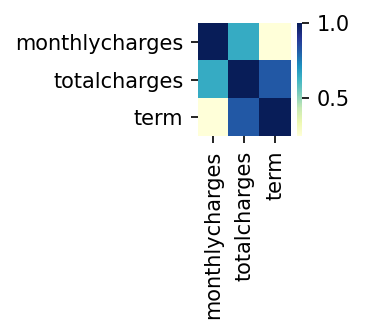

In [69]:
print('\n\033[1mКорреляция\033[0m')
display(itog[['monthlycharges','totalcharges','term']].corr())
fig = plt.subplots(figsize=(1, 1), dpi= 150)
sn.heatmap(itog[['monthlycharges','totalcharges','term']].corr(), annot=False, fmt = 'g', cmap="YlGnBu")


In [70]:
relations = {}
for index, row in itog[['monthlycharges','totalcharges','term']].corr().iterrows():
    for ind_column, item in row.items():
        if index != 'Unnamed: 0' and ind_column != 'Unnamed: 0' and index != ind_column and not(pd.isna (item)):
            find_relation = relations.get(index + ' - ' + ind_column)
            find_relation_revert = relations.get(ind_column + ' - ' + index)
            if find_relation == None and find_relation_revert == None:
                relations[index + ' - ' + ind_column] = round(item,2)
relations_sort = list(relations.items()) 
relations_sort.sort(key=lambda i: math.fabs(i[1]), reverse = True)

relation_kategories = {'Сильная связь (коэффициент > 0.7)':[0.7,1], 'Умеренная связь (0.5 < коэффициент <= 0.7)':[0.5,0.7],'Слабая связь (0.3 < коэффициент <= 0.5)':[0.3,0.5], 'Практически отсутствует (коэффициент <= 0.3)':[0,0.3]}

for relation_kategory in relation_kategories:
    display(relation_kategory)
    for relation_sort in relations_sort:
        if math.fabs(relation_sort[1]) > relation_kategories[relation_kategory][0] and math.fabs(relation_sort[1]) <= relation_kategories[relation_kategory][1]:
            display(f'{relation_sort[0]} - {relation_sort[1]}')    

'Сильная связь (коэффициент > 0.7)'

'totalcharges - term - 0.83'

'Умеренная связь (0.5 < коэффициент <= 0.7)'

'monthlycharges - totalcharges - 0.65'

'Слабая связь (0.3 < коэффициент <= 0.5)'

'Практически отсутствует (коэффициент <= 0.3)'

'monthlycharges - term - 0.25'

Учтем большой коэффициент взаимосвязи между  totalcharges и term (0.83), а также между monthlycharges и totalcharges (0.65) - исключим из выборки колонку totalcharges. 

In [71]:
backup_itog = itog.copy()

In [72]:
itog = itog.drop(['totalcharges'],axis = 1)

3. Создание выборок для исследования моделей:

In [73]:
features = itog.drop('leaving', axis = 1)
target = itog['leaving']

Так как не предоставлена отдельная тестовая выборка: выделим ее из исходных данных до начала обучения. Разобьем исходные данные на 2 выборки: обучающую (train) и тестовую (test) в соотношении 3:1 для целевого признака и остальных признаков. Выделять валидационную выборку не будем, так как будет использоваться кросс-валидация на обучающей выборке:

In [74]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345) 
print('Размер обучающей выборки:',features_train.shape)
print('Размер тестовой выборки:',features_test.shape)

Размер обучающей выборки: (5282, 21)
Размер тестовой выборки: (1761, 21)


4. Масштабирование числовых признаков:

In [75]:
numeric = ['monthlycharges', 'term']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric]  = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric]) 

In [76]:
display(features_train)

,paperlessbilling,monthlycharges,term,gender,seniorcitizen,partner,dependents,onlinesecurity,onlinebackup,deviceprotection,...,streamingtv,streamingmovies,multiplelines,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,internetservice_DSL,internetservice_Fiber optic
customerID,,,,,,,,,,,,,,,,,,,,,
0422-OHQHQ,0,-1.4759,-0.7197,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
6656-GULJQ,1,0.6171,1.6093,1,0,1,1,1,0,1,...,1,1,1,0,1,1,0,0,1,0
8967-SZQAS,0,-0.4826,-0.7599,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
6711-VTNRE,1,0.7499,0.1373,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
5913-INRQV,0,0.8363,0.0580,1,1,1,0,1,0,0,...,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9799-CAYJJ,1,0.1437,-1.2502,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
0975-VOOVL,0,-1.1885,-1.2099,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
2878-RMWXY,1,1.2516,1.6093,1,1,1,0,1,1,1,...,0,1,1,0,1,1,0,0,0,1


5. Исследование дисбаланса классов:

Распределение классов по обучающей выборке: 
0   0.7359
1   0.2641
Name: leaving, dtype: float64
Дисбаланс классов в обучающей выборке: 2.786379928315412
Распределение классов по тестовой выборке: 
0   0.7308
1   0.2692
Name: leaving, dtype: float64
Дисбаланс классов в тестовой выборке: 2.7151898734177218


<AxesSubplot:title={'center':'Распределение классов по тестовой выборке'}>

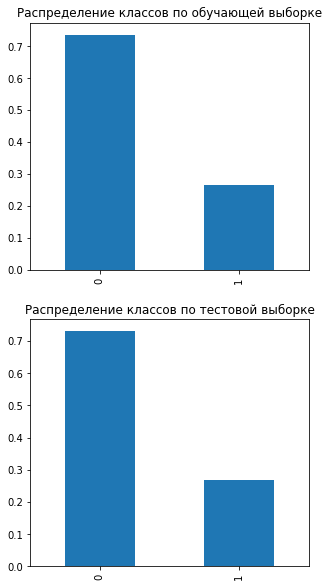

In [77]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(5, 10))


class_frequency_train = target_train.value_counts(normalize = True)
print('\033[1m' + 'Распределение классов по обучающей выборке: ' + '\033[0m')
print(class_frequency_train)
print('Дисбаланс классов в обучающей выборке: ' + '\033[1m' + str(class_frequency_train[0] / class_frequency_train[1]) +  '\033[0m' )
class_frequency_train.plot(kind='bar', ax = ax1, title = 'Распределение классов по обучающей выборке')

class_frequency_test = target_test.value_counts(normalize = True)
print('\033[1m' + 'Распределение классов по тестовой выборке: ' + '\033[0m')
print(class_frequency_test)
print('Дисбаланс классов в тестовой выборке: ' + '\033[1m' + str(class_frequency_test[0] / class_frequency_test[1]) +  '\033[0m' )

class_frequency_test.plot(kind='bar', ax = ax2, title = 'Распределение классов по тестовой выборке')

Все выборки показали дисбаланс классов, избавляться от которого будем встроенными механизмами моделей.

# Обучение моделей

Исследуем следующие модели бинарной классификации. В качестве основной метрики будем использовать ROC-AUC, в дополнительно рассчитаем accuracy_score. 

<b> 1) модель LogisticRegression:

In [78]:
itog_feature_important = {}

In [79]:
def feature_important(grid_cv, X_train,name):
    try:
        temp = pd.DataFrame(data = grid_cv.best_estimator_.feature_importances_).T
        temp.columns = X_train.columns
        itog_feature_important[name]=[temp]
    except:
        return    
        

In [80]:
%%time

model = LogisticRegression()
hyperparams = [{'solver':['liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':['balanced']}] 

# подбор гиперпараметров
rnd_search = GridSearchCV(model, hyperparams, scoring =['f1', 'accuracy', 'roc_auc'], refit = 'roc_auc',cv=3)
rnd_search.fit(features_train, target_train)

best_params_LogisticRegression = rnd_search.best_params_
# вывод наилучших гиперпараметров
print('\n' + '\033[1m' + 'Критерии и лучшие гиперпараметры для модели LogisticRegression:'  + '\033[0m', best_params_LogisticRegression)
# feature_important(rnd_search, features_train, 'LogisticRegression')


Критерии и лучшие гиперпараметры для модели LogisticRegression: {'C': 10, 'class_weight': 'balanced', 'solver': 'liblinear'}
CPU times: total: 141 ms
Wall time: 132 ms


In [81]:
itog_valid={}
def roc_auc_acc_valid(model, name):
    model.fit(features_train, target_train)
    roc_val = cross_val_score(model, features_train, target_train, cv=3, scoring='roc_auc').mean()
    acc_val = cross_val_score(model, features_train, target_train, cv=3, scoring='accuracy').mean()
    f1_val = cross_val_score(model, features_train, target_train, cv=3, scoring='f1').mean()
    
    print('Значение метрики' + '\033[1m ' +  'ROC-AUC' +  '\033[0m' + ' модели ' + name + ' на обучающей выборке с кросс-валидацией = ' +  
          '\033[1m ' + str(roc_val) + '\033[0m\n')
    print('Значение метрики' + '\033[1m ' +  'accuracy' +   '\033[0m' + ' модели ' + name + ' на обучающей выборке с кросс-валидацией = ' + 
          '\033[1m ' + str(acc_val) + '\033[0m\n')
    print('Значение метрики' + '\033[1m ' +  'F1' +   '\033[0m' + ' модели ' + name + ' на обучающей выборке с кросс-валидацией = ' + 
          '\033[1m ' + str(f1_val) + '\033[0m\n') 
    itog_valid[name]=[roc_val, acc_val, f1_val]

In [82]:
%%time

model_LR = LogisticRegression()
model_LR.set_params(**best_params_LogisticRegression)
roc_auc_acc_valid(model_LR,'LogisticRegression')


Значение метрики ROC-AUC модели LogisticRegression на обучающей выборке с кросс-валидацией =  0.8429510911320947

Значение метрики accuracy модели LogisticRegression на обучающей выборке с кросс-валидацией =  0.7510393543613306

Значение метрики F1 модели LogisticRegression на обучающей выборке с кросс-валидацией =  0.6254201884776062

CPU times: total: 125 ms
Wall time: 120 ms


<b> 2) модель RandomForestClassifier:

In [83]:
%%time

model = RandomForestClassifier()
min_samples_leaf_list = [x for x in range(1, 5)]
max_depth_list = [x for x in range(2, 10)]
n_estimators_list = [x for x in range(100,201,10)]
hyperparams = [{'min_samples_leaf':min_samples_leaf_list,'class_weight':['balanced'], 
                'max_depth':max_depth_list, 'n_estimators':n_estimators_list,
                'random_state':[123456], 'n_jobs':[-1]}]

# подбор гиперпараметров

rnd_search = GridSearchCV(model, hyperparams, scoring =['f1', 'accuracy', 'roc_auc'], refit = 'roc_auc',cv=3)
rnd_search.fit(features_train,target_train)
best_params_RandomForestClassifier = rnd_search.best_params_

# вывод наилучших гиперпараметров
print('\n' + '\033[1m' + 'Критерии и лучшие гиперпараметры для модели RandomForestClassifier:'  + '\033[0m', 
      best_params_RandomForestClassifier)
feature_important(rnd_search, features_train, 'RandomForestClassifier')



Критерии и лучшие гиперпараметры для модели RandomForestClassifier: {'class_weight': 'balanced', 'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 150, 'n_jobs': -1, 'random_state': 123456}
CPU times: total: 3min 56s
Wall time: 4min 17s


In [84]:
%%time

model_RFC = RandomForestClassifier()
model_RFC.set_params(**best_params_RandomForestClassifier)
roc_auc_acc_valid(model_RFC,'RandomForestClassifier')


Значение метрики ROC-AUC модели RandomForestClassifier на обучающей выборке с кросс-валидацией =  0.8552013611153396

Значение метрики accuracy модели RandomForestClassifier на обучающей выборке с кросс-валидацией =  0.7849272107789996

Значение метрики F1 модели RandomForestClassifier на обучающей выборке с кросс-валидацией =  0.6465260591743335

CPU times: total: 2.39 s
Wall time: 2.58 s


<b> 3) модель DecisionTreeClassifier:

In [85]:
%%time

model = DecisionTreeClassifier()
max_features_list = [x for x in range(1, 10)]
max_depth_list = [x for x in range(2, 10)]
hyperparams = [{'max_features':max_features_list,'class_weight':['balanced'], 
                'max_depth':max_depth_list,
                'random_state':[123456]}]

# подбор гиперпараметров

rnd_search = GridSearchCV(model, hyperparams, scoring =['f1', 'accuracy', 'roc_auc'], refit = 'roc_auc',cv=3)
rnd_search.fit(features_train,target_train)
best_params_DecisionTreeClassifier = rnd_search.best_params_

# вывод наилучших гиперпараметров
print('\n' + '\033[1m' + 'Критерии и лучшие гиперпараметры для модели DecisionTreeClassifier:'  + '\033[0m', 
      best_params_DecisionTreeClassifier)
feature_important(rnd_search, features_train, 'DecisionTreeClassifier')



Критерии и лучшие гиперпараметры для модели DecisionTreeClassifier: {'class_weight': 'balanced', 'max_depth': 6, 'max_features': 9, 'random_state': 123456}
CPU times: total: 2.45 s
Wall time: 2.49 s


In [86]:
%%time

model_DTC = DecisionTreeClassifier()
model_DTC.set_params(**best_params_DecisionTreeClassifier)
roc_auc_acc_valid(model_DTC,'DecisionTreeClassifier')


Значение метрики ROC-AUC модели DecisionTreeClassifier на обучающей выборке с кросс-валидацией =  0.8289311685383968

Значение метрики accuracy модели DecisionTreeClassifier на обучающей выборке с кросс-валидацией =  0.7319214289401682

Значение метрики F1 модели DecisionTreeClassifier на обучающей выборке с кросс-валидацией =  0.6027311600968891

CPU times: total: 78.1 ms
Wall time: 113 ms


<b> 4) модель CatBoostClassifier:

In [87]:
%%time
rate_0_1 = itog['leaving'].value_counts(normalize = True)[0] / itog['leaving'].value_counts(normalize = True)[1]

model = CatBoostClassifier()

hyperparams = [{'learning_rate':[x/10 for x in range(1, 9)],'class_weights':[{0:1, 1:rate_0_1}],
                'random_state':[123456],'max_depth':[x for x in range(1, 11, 2)],'n_estimators':[x for x in range(1, 121,30)],
                'verbose':[False]}]

# подбор гиперпараметров

rnd_search = GridSearchCV(model, hyperparams, scoring =['f1', 'accuracy', 'roc_auc'], refit = 'roc_auc',cv=3)
rnd_search.fit(features_train,target_train)
best_params_CatBoostClassifier = rnd_search.best_params_

# вывод наилучших гиперпараметров
print('\n' + '\033[1m' + 'Критерии и лучшие гиперпараметры для модели CatBoostClassifier:'  + '\033[0m', 
      best_params_CatBoostClassifier)

feature_important(rnd_search, features_train, 'CatBoostClassifier')


Критерии и лучшие гиперпараметры для модели CatBoostClassifier: {'class_weights': {0: 1, 1: 2.76832530765115}, 'learning_rate': 0.8, 'max_depth': 3, 'n_estimators': 91, 'random_state': 123456, 'verbose': False}
CPU times: total: 3min 2s
Wall time: 1min 27s


In [88]:
%%time

model_CBC = CatBoostClassifier()
model_CBC.set_params(**best_params_CatBoostClassifier)
roc_auc_acc_valid(model_CBC,'CatBoostClassifier')


Значение метрики ROC-AUC модели CatBoostClassifier на обучающей выборке с кросс-валидацией =  0.9071265289440319

Значение метрики accuracy модели CatBoostClassifier на обучающей выборке с кросс-валидацией =  0.832827529984685

Значение метрики F1 модели CatBoostClassifier на обучающей выборке с кросс-валидацией =  0.7142277634200692

CPU times: total: 2.94 s
Wall time: 1.4 s


<b> 5) модель LGBMClassifier:

In [89]:
%%time

model = lgbm.LGBMClassifier()

max_depth_list = [x for x in range(1, 25)]
hyperparams = [{'learning_rate':[x/10 for x in range(1, 9)],'max_depth':max_depth_list,'n_estimators':[x for x in range(10, 201 ,20)],
                'random_state':[123456],'class_weight':['balanced']}]

# подбор гиперпараметров

rnd_search = GridSearchCV(model, hyperparams, scoring =['f1', 'accuracy', 'roc_auc'], refit = 'roc_auc',cv=3)
rnd_search.fit(features_train,target_train)
best_params_LGBMClassifier = rnd_search.best_params_

# вывод наилучших гиперпараметров
print('\n' + '\033[1m' + 'Критерии и лучшие гиперпараметры для модели LGBMClassifier:'  + '\033[0m', 
      best_params_LGBMClassifier)

feature_important(rnd_search, features_train, 'LGBMClassifier')


Критерии и лучшие гиперпараметры для модели LGBMClassifier: {'class_weight': 'balanced', 'learning_rate': 0.7, 'max_depth': 2, 'n_estimators': 190, 'random_state': 123456}
CPU times: total: 23min 51s
Wall time: 8min 12s


In [90]:
%%time

model_LGBMC = lgbm.LGBMClassifier()
model_LGBMC.set_params(**best_params_LGBMClassifier)
roc_auc_acc_valid(model_LGBMC,'LGBMClassifier')


Значение метрики ROC-AUC модели LGBMClassifier на обучающей выборке с кросс-валидацией =  0.9057323405501422

Значение метрики accuracy модели LGBMClassifier на обучающей выборке с кросс-валидацией =  0.8373714788429439

Значение метрики F1 модели LGBMClassifier на обучающей выборке с кросс-валидацией =  0.7205334088597185

CPU times: total: 1.45 s
Wall time: 514 ms


<b> 6) модель XGBClassifier:

In [91]:
%%time
rate_0_1 = itog['leaving'].value_counts(normalize = True)[0] / itog['leaving'].value_counts(normalize = True)[1]
model = xgb.XGBClassifier()

max_depth_list = [x for x in range(1, 25,2)]
hyperparams = [{'learning_rate':[x/10 for x in range(1, 9, 2)],'max_depth':max_depth_list,'n_estimators':[x for x in range(10, 121,10)],
                'random_state':[123456], 'scale_pos_weight':[rate_0_1] }]

# подбор гиперпараметров

rnd_search = GridSearchCV(model, hyperparams, scoring =['f1', 'accuracy', 'roc_auc'], refit = 'roc_auc',cv=3)
rnd_search.fit(features_train,target_train)
best_params_XGBClassifier = rnd_search.best_params_

# вывод наилучших гиперпараметров
print('\n' + '\033[1m' + 'Критерии и лучшие гиперпараметры для модели XGBClassifier:'  + '\033[0m', 
      best_params_XGBClassifier)
feature_important(rnd_search, features_train, 'XGBClassifier')


Критерии и лучшие гиперпараметры для модели XGBClassifier: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 120, 'random_state': 123456, 'scale_pos_weight': 2.76832530765115}
CPU times: total: 24min 18s
Wall time: 8min 58s


In [92]:
%%time

model_XGBC = xgb.XGBClassifier()
model_LGBMC.set_params(**best_params_XGBClassifier)
roc_auc_acc_valid(model_XGBC,'XGBClassifier')


Значение метрики ROC-AUC модели XGBClassifier на обучающей выборке с кросс-валидацией =  0.8905273442071531

Значение метрики accuracy модели XGBClassifier на обучающей выборке с кросс-валидацией =  0.8479732374855885

Значение метрики F1 модели XGBClassifier на обучающей выборке с кросс-валидацией =  0.6834467019452286

CPU times: total: 7.08 s
Wall time: 4.51 s


In [93]:
itog_df_valid = pd.DataFrame(itog_valid, index=['Метрика ROC-AUC','Метрика accuracy','Метрика F1'])
display(itog_df_valid)

,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,CatBoostClassifier,LGBMClassifier,XGBClassifier
Метрика ROC-AUC,0.8430,0.8552,0.8289,0.9071,0.9057,0.8905
Метрика accuracy,0.7510,0.7849,0.7319,0.8328,0.8374,0.8480
Метрика F1,0.6254,0.6465,0.6027,0.7142,0.7205,0.6834


ТОП-3 моделей по метрике ROC-AUC на обучающей выборке с кросс-валидацией:

1) CatBoostClassifier (ROC-AUC = 0.9071);

2) LGBMClassifier (ROC-AUC = 0.9057);

3) XGBClassifier (ROC-AUC = 0.8905).

Согласно метрике accuracy рейтинг моделей следующий:

1) XGBClassifier (accuracy = 0.8480);

2) LGBMClassifier (accuracy = 0.8374);

3) CatBoostClassifier (accuracy = 0.8328).

Согласно метрике F1 рейтинг моделей следующий:

1) LGBMClassifier (F1 = 0.7205);

2) CatBoostClassifier (F1 = 0.7142);

3) XGBClassifier (F1 = 0.6834).

# Анализ моделей

Проанализируем модели на тестовой выборке:

<b> 1) модель LogisticRegression:

In [94]:
itog_test={}
itog_test_plt={}
def roc_auc_acc_test(model, name):
    predict = model.predict(features_test)

    predict_proba = model.predict_proba(features_test)
    predict_proba_one_valid = predict_proba[:,1]
    roc_val = roc_auc_score(target_test, predict_proba_one_valid)
    acc_val = accuracy_score(predict, target_test)
    f1_val = f1_score(predict, target_test)
    fpr, tpr, thresholds = roc_curve(target_test, predict_proba_one_valid)    
    print('Значение метрики' + '\033[1m ' +  'ROC-AUC' +  '\033[0m' + ' модели ' + name + ' на тестовой выборке = ' +  
          '\033[1m ' + str(roc_val) + '\033[0m\n')
    print('Значение метрики' + '\033[1m ' +  'accuracy' +   '\033[0m' + ' модели ' + name + ' на тестовой выборке = ' + 
          '\033[1m ' + str(acc_val) + '\033[0m\n')
    print('Значение метрики' + '\033[1m ' +  'F1' +   '\033[0m' + ' модели ' + name + ' на тестовой выборке = ' + 
          '\033[1m ' + str(f1_val) + '\033[0m\n') 
    itog_test[name]=[roc_val,acc_val,f1_val]
    itog_test_plt[name]=[fpr, tpr]

In [95]:
%%time

roc_auc_acc_test(model_LR,'LogisticRegression')

Значение метрики ROC-AUC модели LogisticRegression на тестовой выборке =  0.8393313203439785

Значение метрики accuracy модели LogisticRegression на тестовой выборке =  0.7455990914253265

Значение метрики F1 модели LogisticRegression на тестовой выборке =  0.6291390728476821

CPU times: total: 31.2 ms
Wall time: 11 ms


<b> 2) модель RandomForestClassifier:

In [96]:
%%time

roc_auc_acc_test(model_LR,'RandomForestClassifier')

Значение метрики ROC-AUC модели RandomForestClassifier на тестовой выборке =  0.8393313203439785

Значение метрики accuracy модели RandomForestClassifier на тестовой выборке =  0.7455990914253265

Значение метрики F1 модели RandomForestClassifier на тестовой выборке =  0.6291390728476821

CPU times: total: 0 ns
Wall time: 8.54 ms


<b> 3) модель DecisionTreeClassifier:

In [97]:
%%time

roc_auc_acc_test(model_DTC,'DecisionTreeClassifier')

Значение метрики ROC-AUC модели DecisionTreeClassifier на тестовой выборке =  0.8329522095344881

Значение метрики accuracy модели DecisionTreeClassifier на тестовой выборке =  0.7614991482112436

Значение метрики F1 модели DecisionTreeClassifier на тестовой выборке =  0.6269982238010657

CPU times: total: 0 ns
Wall time: 8.92 ms


<b> 4) модель CatBoostClassifier:

In [98]:
%%time

roc_auc_acc_test(model_CBC,'CatBoostClassifier')

Значение метрики ROC-AUC модели CatBoostClassifier на тестовой выборке =  0.9207287087033922

Значение метрики accuracy модели CatBoostClassifier на тестовой выборке =  0.8438387279954571

Значение метрики F1 модели CatBoostClassifier на тестовой выборке =  0.7422680412371134

CPU times: total: 31.2 ms
Wall time: 8.93 ms


<b> 5) модель LGBMClassifier:

In [99]:
%%time

roc_auc_acc_test(model_LGBMC,'LGBMClassifier')

Значение метрики ROC-AUC модели LGBMClassifier на тестовой выборке =  0.9257021693730555

Значение метрики accuracy модели LGBMClassifier на тестовой выборке =  0.8489494605337876

Значение метрики F1 модели LGBMClassifier на тестовой выборке =  0.747628083491461

CPU times: total: 62.5 ms
Wall time: 17.1 ms


<b> 6) модель XGBClassifier:

In [100]:
%%time

roc_auc_acc_test(model_XGBC,'XGBClassifier')

Значение метрики ROC-AUC модели XGBClassifier на тестовой выборке =  0.9103932869755654

Значение метрики accuracy модели XGBClassifier на тестовой выборке =  0.8676888131743328

Значение метрики F1 модели XGBClassifier на тестовой выборке =  0.7249114521841794

CPU times: total: 0 ns
Wall time: 10 ms


In [101]:
itog_df_test = pd.DataFrame(itog_test, index=['Метрика ROC-AUC','Метрика accuracy','Метрика F1'])
display(itog_df_test)

,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,CatBoostClassifier,LGBMClassifier,XGBClassifier
Метрика ROC-AUC,0.8393,0.8393,0.8330,0.9207,0.9257,0.9104
Метрика accuracy,0.7456,0.7456,0.7615,0.8438,0.8489,0.8677
Метрика F1,0.6291,0.6291,0.6270,0.7423,0.7476,0.7249


ТОП-3 моделей по метрике ROC-AUC на тестовой выборке:

1) LGBMClassifier (ROC-AUC = 0.9257);

2) CatBoostClassifier (ROC-AUC = 0.9207);

3) XGBClassifier (ROC-AUC = 0.9104).

Согласно метрике accuracy рейтинг моделей следующий:

1) XGBClassifier (accuracy = 0.8677);

2) LGBMClassifier (accuracy = 0.8489);

3) CatBoostClassifier (accuracy = 0.8438).

Согласно метрике F1 рейтинг моделей следующий:

1) LGBMClassifier (F1 = 0.7476);

2) CatBoostClassifier (F1 = 0.7423);

3) XGBClassifier (F1 = 0.7249).

Таким образом, лучшие результаты в большей части метрик показала модель LGBMClassifier.

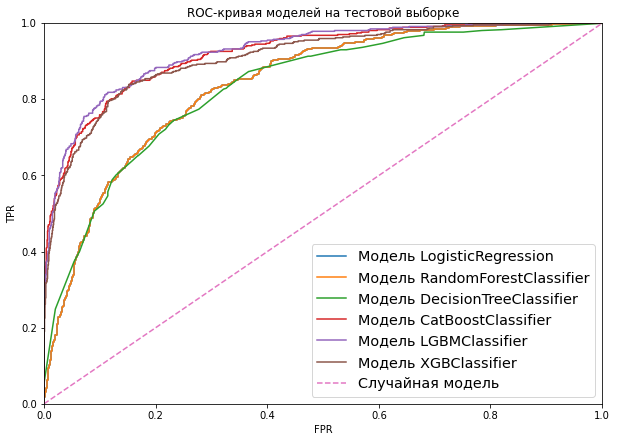

In [102]:
plt.figure(figsize=[10,7])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-кривая моделей на тестовой выборке")
for key,value in itog_test_plt.items():
    plt.plot(value[0], value[1], label='Модель ' + key) 
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
plt.legend(loc='lower right', fontsize='x-large')
plt.show()

Исследуем факторы, влияющие на целевой признак, для каждой модели:

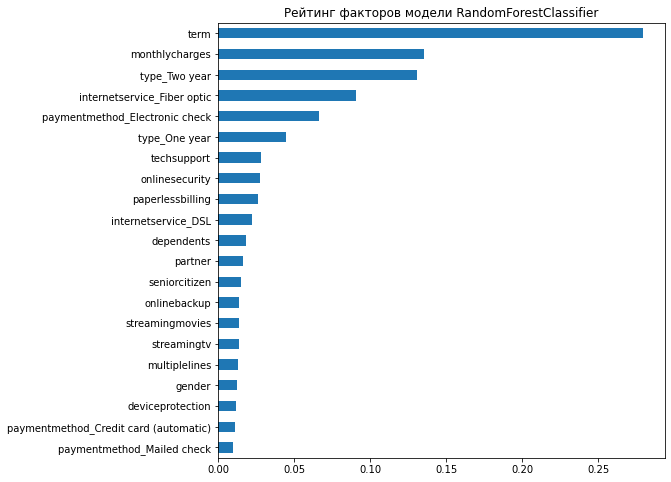

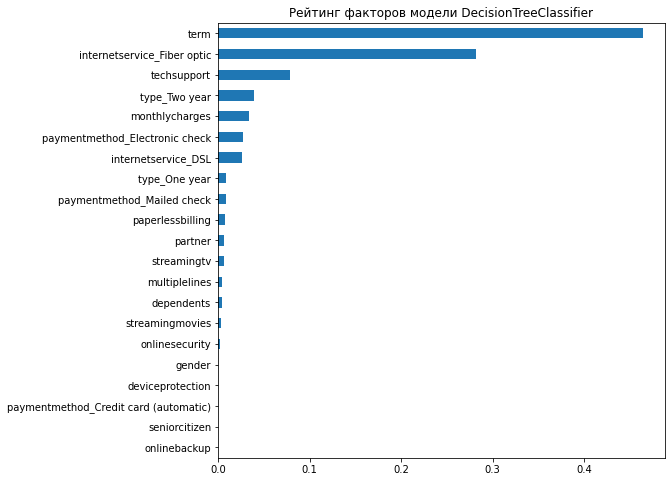

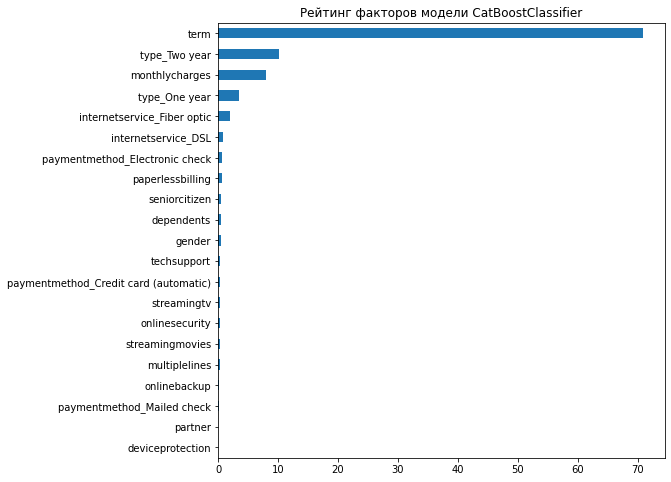

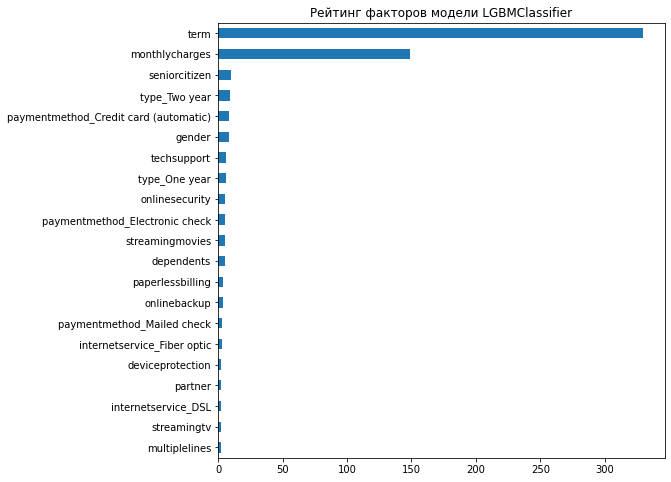

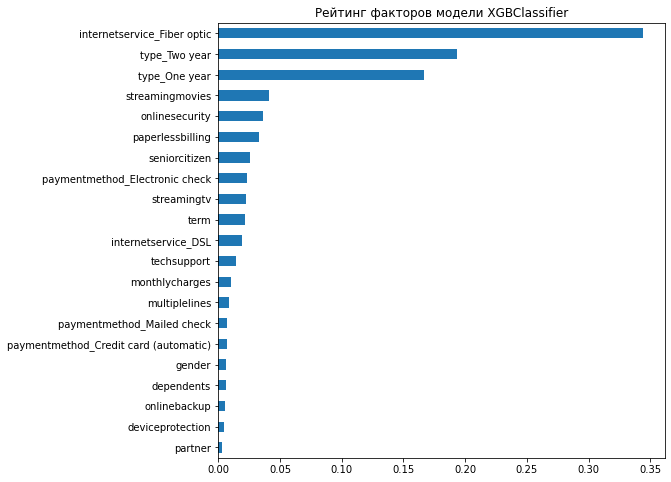

In [103]:
for key,value in itog_feature_important.items():
    value[0].T.sort_values(by=0, ascending=True).plot(kind='barh', figsize=(8,8), legend = False)
    plt.title('Рейтинг факторов модели ' + key)
    plt.show()

У моделей, показавших наилучшую оценку, определяющими факторами являются: term, monthlycharges, в меньшей степени - тип оплаты (1 раз в год, 2 раза в год). Модель XGBClassifier выделила важным фактором internetservice_fiber optic. В модели CatboostClassifier нулевыми факторами являются: deviceprotection, partner, onlinebackup, paymentmethod_mailed check. В других моделях эти факторы также имеют небольшой вес. По графику виден механизм работы каждой модели: так модель XGBClassifier не теряет важность всех факторов, в то же время модели CatboostClassifier и LGBMClassifier сильно выделяют несколько факторов, а оставшимся дают низкий вес, вплоть до нулевого.

<b> Выводы: </b>

Учитывая оценку факторов наилучших моделей, а также аналитику, проведенную ранее можно установить: такие факторы как пол клиента, наличие у клиента супруга и иждивенцев, наличие (отсутствие) услуги onlinebackup, deviceprotection, streamingtv и streamingmovies, multiplelines, чек об оплате на почту, оплата через кредитную карту или банковский трансфер не являются значимыми факторами при прогнозировании оттока клиентов, в то же время следует учесть такие факторы как срок договора, порядок оплаты, размер ежемесячного платежа и наличие оптоволоконного соединения.

Я для себя выделила бы как наиболее отражающий действительность рейтинг факторов, заданных моделью XGBClassifier. Кроме того данная модель учитывает их все, не снижая веса до нулевых значений. Возможна такая ситуация, когда в будущем какой-либо из этих факторов усилит влияние на отток (например, клиенты будут активно пользоваться онлайн-бэкапом), и исключать этот фактор из модели не стоит.

# Отчет по проекту

Цель проекта - построение модели, прогнозирующей отток клиентов на основании различных факторов.

В ходе проекта были выполнены следующие этапы:

    1. Исследовательский анализ данных: 
    
   На данном этапе были загружены исходные данные и выполнен предварительный анализ. 
    
   Установлено отсутствие целевого фактора в явном виде, потребовалось его выделение на основе фактора EndDate (действующие клиенты - значение фактора EndDate не заполнено, ушедшие клиенты - значение фактора заполнено). 
    
   В ходе исследования выявлены 2 фактора, BeginDate и EndDate, которые требуют замены новым фактором - длительностью договора с клиентом, так как мы не исследуем временные ряды.  
    
   В факторе EndDate были выявлены отсутствующие значения (отсутствие статистики, соответствующее действующим клиентам), которые необходимо заменить датой сбора информации. 
    
   В факторе TotalCharges были выявлены отсутствующие значения (отсутствие статистики), которые необходимо заменить значением фактора Мonthlycharges. 
    
    2. Предобработка данных:
    
   На данном этапе выполнено: приведение типов, замена отсутствующих значений факторов EndDate и TotalCharges, выделение целевого признака на основе значений колонки EndDate, замена признаков BeginDate и EndDate сроком действия договора, объединение таблиц. 
   
   Поскольку в данных присутствует статистика по клиентам, которые могут пользоваться один из видов услуг (интернет или телефония), то возникли пропуски, которые потребовали дополнительной предобработки.
   
    3. Подготовка выборок: 
    
   На данном этапе выполнено приведение категориальных признаков к числовым (бинарные категориальные признаки приведены к значениям 0 и 1, к остальным категориальным признакам применялось One-Hot Encoding). 
   
   При анализе корреляции числовых признаков выявлена корреляция между признаком TotalCharges и признаком Мonthlycharges, а также между признаком TotalCharges и длительностью договора с клиентом, поэтому признак TotalCharges был исключен. 
   
   Вся выборка была разделена на обучающую (так как использовалась кросс-валидация моделей) и тестовую в соотношении 3:1, для каждой выборки выполнено масштабирование численных признаков.
   
   В ходе исследования был выявлен дисбаланс классов.
    
    4. Обучение моделей: 
    
   На данном этапе исследовались модели бинарной классификации: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, CatBoostClassifier, LGBMClassifier, XGBClassifier. 
   
   Для каждой модели были подобраны гиперпараметры, дающие лучшую целевую метрику ROC-AUC. При обучении использовались встроенные механизмы моделей, учитывающие дисбаланс входных классов.
   
   На моделях, обученных на обучающей выборке с кросс-валидацией, для сравнительного анализа была получена метрика ROC-AUC, а также дополнительно метрики accuracy и F1-мера.
    
    5. Анализ моделей:
    
   На тестовой выборке для каждой модели получены метрики ROC-AUC, accuracy и F1-мера, и выполнен сравнительный анализ. 
   
   В качестве лучшей модели выбрана модель LGBMClassifier (параметры: {'class_weight': 'balanced', 'learning_rate': 0.7, 'max_depth': 2, 'n_estimators': 190, 'random_state': 123456}) с лучшей метрикой ROC-AUC, равной 0.9257.
   
   Кроме того, для каждой обученной модели был составлен рейтинг факторов. С учетом оценки факторов наилучших моделей, а также аналитики установлено: такие факторы, как пол клиента, наличие у клиента супруга и иждивенцев, наличие (отсутствие) услуги onlinebackup, deviceprotection, streamingtv и streamingmovies, multiplelines, чек об оплате на почту, оплата через кредитную карту или банковский трансфер не являются значимыми факторами при прогнозировании оттока клиентов, в то же время следует учесть такие факторы как срок договора, порядок оплаты, размер ежемесячного платежа и способ подключения интернета через оптоволокно.

